# Fake News Classifier Project

## By Phelipe Martins

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [1]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras import layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import csv
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
#Evaluate model performance.
from sklearn import metrics
from html import unescape
import matplotlib.pyplot as plt
import numpy as np
import itertools
from numpy import argmax
from keras.utils import to_categorical

Using TensorFlow backend.


## Function to create confusion matrix

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [3]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
def plot_line_chart(x, y, xlabel, ylabel, title):
    x = x
    y = y
    plt.plot(x, y, color='g')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Reading .csv files (1.000 datas - low, 10.000 datas - medium, 100.000 datas - large)

In [5]:
df_news_cleaned_low = pd.read_csv("C:\\Users\\phelipegm\\Documents\\fake_news_dataset\\news_cleaned_low.csv")

df_news_cleaned_medium = pd.read_csv("C:\\Users\\phelipegm\\Documents\\fake_news_dataset\\news_cleaned_medium.csv")

df_news_cleaned_large = pd.read_csv("C:\\Users\\phelipegm\\Documents\\fake_news_dataset\\news_cleaned_large.csv")

df_news_cleaned_low = df_news_cleaned_low.drop('Unnamed: 0', axis=1)
df_news_cleaned_low = df_news_cleaned_low.drop('Unnamed: 0.1', axis=1)
df_news_cleaned_low = df_news_cleaned_low.sort_values(by=['id'])

df_news_cleaned_medium = df_news_cleaned_medium.drop('Unnamed: 0', axis=1)
df_news_cleaned_medium = df_news_cleaned_medium.drop('Unnamed: 0.1', axis=1)
df_news_cleaned_medium = df_news_cleaned_medium.sort_values(by=['id'])

df_news_cleaned_large = df_news_cleaned_large.drop('Unnamed: 0', axis=1)
df_news_cleaned_large = df_news_cleaned_large.drop('Unnamed: 0.1', axis=1)
df_news_cleaned_large = df_news_cleaned_large.sort_values(by=['id'])

In [6]:
df_news_cleaned_low.head()

,id,domain,type,content,title
809,11737,beforeitsnews.com,FAKE,Trump: “Defining Deviancy Down” With Lots of T...,Trump: “Defining Deviancy Down” With Lots of T...
378,12512,beforeitsnews.com,FAKE,Ron Paul predicts a Libertarian will run compe...,Ron Paul predicts a Libertarian will run compe...
973,15206,beforeitsnews.com,FAKE,See a Flirtatious Lunar Eclipse This Friday Ni...,See a Flirtatious Lunar Eclipse This Friday Night
722,16849,beforeitsnews.com,FAKE,How Snowden proved Congress needs to Read the ...,How Snowden proved Congress needs to Read the ...
499,19053,beforeitsnews.com,FAKE,U.S. Gives Soros Groups Millions to Destabiliz...,U.S. Gives Soros Groups Millions to Destabiliz...


In [10]:
df_news_cleaned_medium.head()

,id,domain,type,content,title
6583,1074,christianpost.com,REAL,(Photo: REUTERS/Jason Lee) A cross is seen beh...,"Chinese Gov't Fines Pastors Over $1M, Demandin..."
6039,1249,beforeitsnews.com,FAKE,"Healthy to Eat, Unhealthy to Grow: Strawberrie...","Healthy to Eat, Unhealthy to Grow: Strawberrie..."
4001,3052,christianpost.com,REAL,(Photo: Reuters/Jayanta Shaw) School children ...,Thousands of Indian Christians Protest After P...
7137,5201,beforeitsnews.com,FAKE,Headline: Bitcoin & Blockchain Searches Exceed...,Jordan Peterson: Everything you do matters. Tr...
9245,6548,beforeitsnews.com,FAKE,Looming Catastrophe Hanging Over Our Heads – G...,Looming Catastrophe Hanging Over Our Heads – G...


In [11]:
df_news_cleaned_large.head()

,id,domain,type,content,title
94889,449,beforeitsnews.com,FAKE,Have You Seen Palladium’s Tradable Price Patte...,Have You Seen Palladium’s Tradable Price Pattern?
69808,471,christianpost.com,REAL,REUTERS/Pawel Kopczynski An illustration pictu...,NSA Has Been Running a Voice-Recognition Syste...
17544,518,christianpost.com,REAL,(Screengrab: YouTube / ABC15 Arizona) Evangeli...,Franklin Graham Responds to Trump-Porn Star Al...
30926,643,christianpost.com,REAL,(Photo: Reuters/Jasen Vinlove/USA TODAY Sports...,Tim Tebow Continues to Defy Odds: N.Y. Mets In...
37790,726,beforeitsnews.com,FAKE,Sienna Resources kicks off ground survey at ex...,Sienna Resources kicks off ground survey at ex...


In [33]:
df_news_cleaned_low.shape

(1000, 5)

In [35]:
df_news_cleaned_medium.shape

(10000, 5)

In [36]:
df_news_cleaned_large.shape

(100000, 5)

In [29]:
df_news_cleaned_low.isnull().sum()

id         0
domain     0
type       0
content    0
title      0
dtype: int64

## Some preprocessing functions

In [20]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()
stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)


# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_  if token.lemma_ != '-PRON-' else token.lower_ for token in tokens])

In [21]:
y = df_news_cleaned_low.type

#getting the training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_news_cleaned_low.content, y, test_size =0.33, random_state=53)

### Using Tfidf

In [22]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

c:\users\phelipegm\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [188]:
print(tfidf_vectorizer.get_feature_names())

['2', '3', '4', '5', 'abandon', 'ability', 'able', 'abuse', 'academy', 'accept', 'access', 'accompany', 'accord', 'account', 'accuse', 'achieve', 'acknowledge', 'act', 'action', 'active', 'activity', 'actually', 'add', 'addition', 'additional', 'address', 'adjust', 'administration', 'admit', 'adult', 'advance', 'advantage', 'advertise', 'advertisement', 'advocate', 'affair', 'affect', 'africa', 'african', 'afternoon', 'age', 'agency', 'agent', 'ago', 'agree', 'agreement', 'ahead', 'aid', 'aim', 'air', 'al', 'alert', 'allow', 'ally', 'alternative', 'america', 'american', 'americans', 'amid', 'analysis', 'analyst', 'andrew', 'angeles', 'animal', 'anniversary', 'announce', 'announcement', 'annual', 'answer', 'anti', 'ap', 'apartment', 'apparently', 'appeal', 'appear', 'appearance', 'application', 'apply', 'approach', 'approve', 'april', 'area', 'argue', 'argument', 'arm', 'army', 'arrest', 'arrive', 'art', 'article', 'artist', 'asia', 'aside', 'ask', 'aspect', 'asset', 'assistant', 'assoc

### Using Naive Bayes classifier - Tfidf

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.85455
Alpha: 0.02 Score: 0.85455
Alpha: 0.03 Score: 0.85758
Alpha: 0.04 Score: 0.85758
Alpha: 0.05 Score: 0.85758
Alpha: 0.06 Score: 0.85758
Alpha: 0.07 Score: 0.85758
Alpha: 0.08 Score: 0.85758
Alpha: 0.09 Score: 0.85758
Alpha: 0.10 Score: 0.86364
Alpha: 0.11 Score: 0.86364
Alpha: 0.12 Score: 0.85758
Alpha: 0.13 Score: 0.85758
Alpha: 0.14 Score: 0.85758
Alpha: 0.15 Score: 0.85758
Alpha: 0.16 Score: 0.86061
Alpha: 0.17 Score: 0.86061
Alpha: 0.18 Score: 0.86061
Alpha: 0.19 Score: 0.86061
Alpha: 0.20 Score: 0.86061
Alpha: 0.21 Score: 0.86061
Alpha: 0.22 Score: 0.86061
Alpha: 0.23 Score: 0.85758
Alpha: 0.24 Score: 0.85758
Alpha: 0.25 Score: 0.85758
Alpha: 0.26 Score: 0.85758
Alpha: 0.27 Score: 0.85758
Alpha: 0.28 Score: 0.85758
Alpha: 0.29 Score: 0.85758
Alpha: 0.30 Score: 0.85758
Alpha: 0.31 Score: 0.85455
Alpha: 0.32 Score: 0.85455
Alpha: 0.33 Score: 0.85455
Alpha: 0.34 Score: 0.85455
Alpha: 0.35 Score: 

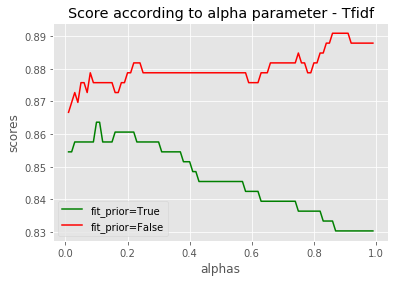

In [23]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier.fit(tfidf_train, y_train)
    nb_pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, nb_pred)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier.fit(tfidf_train, y_train)
    nb_pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, nb_pred)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - Tfidf')
plt.show()




Best alpha:  0.86


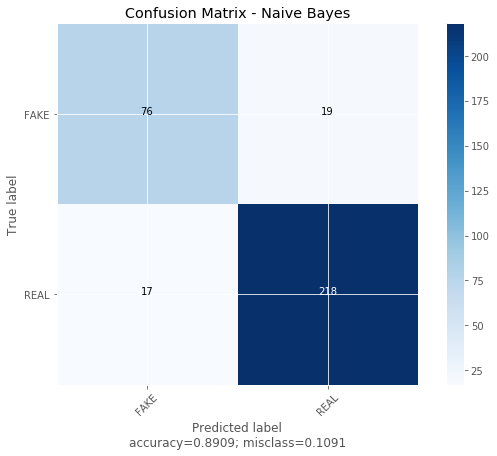

In [24]:
# USING BEST PARAMETERS 

print('\nBest alpha: ', best_alpha)


#best alpha = 0.1
nb_classifier = MultinomialNB(alpha=best_alpha, fit_prior=fit_prior)

    
#this will determine the internal parameters based on the dataset.
nb_classifier.fit(tfidf_train, y_train)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred = nb_classifier.predict(tfidf_test)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm = metrics.confusion_matrix(y_test, nb_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

C: 0.01 Score: 0.71212
C: 0.02 Score: 0.71212
C: 0.03 Score: 0.71212
C: 0.04 Score: 0.71212
C: 0.05 Score: 0.71212
C: 0.06 Score: 0.71212
C: 0.07 Score: 0.71212
C: 0.08 Score: 0.71212
C: 0.09 Score: 0.71515
C: 0.10 Score: 0.71818
C: 0.11 Score: 0.72121
C: 0.12 Score: 0.73030
C: 0.13 Score: 0.73939
C: 0.14 Score: 0.74545
C: 0.15 Score: 0.74545
C: 0.16 Score: 0.75758
C: 0.17 Score: 0.75758
C: 0.18 Score: 0.76061
C: 0.19 Score: 0.76970
C: 0.20 Score: 0.77273
C: 0.21 Score: 0.77879
C: 0.22 Score: 0.78182
C: 0.23 Score: 0.78788
C: 0.24 Score: 0.79697
C: 0.25 Score: 0.80909
C: 0.26 Score: 0.80909
C: 0.27 Score: 0.81515
C: 0.28 Score: 0.81818
C: 0.29 Score: 0.82121
C: 0.30 Score: 0.82424
C: 0.31 Score: 0.82727
C: 0.32 Score: 0.83030
C: 0.33 Score: 0.83636
C: 0.34 Score: 0.83333
C: 0.35 Score: 0.83939
C: 0.36 Score: 0.84242
C: 0.37 Score: 0.84545
C: 0.38 Score: 0.85152
C: 0.39 Score: 0.85455
C: 0.40 Score: 0.85758
C: 0.41 Score: 0.86061
C: 0.42 Score: 0.86667
C: 0.43 Score: 0.86970
C: 0.44 Sco

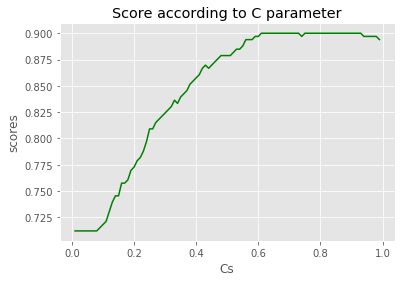

In [274]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier = svm.SVC(kernel ='linear', C=C)
    svm_classifier.fit(tfidf_train, y_train)
    svm_pred = svm_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, svm_pred)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.61


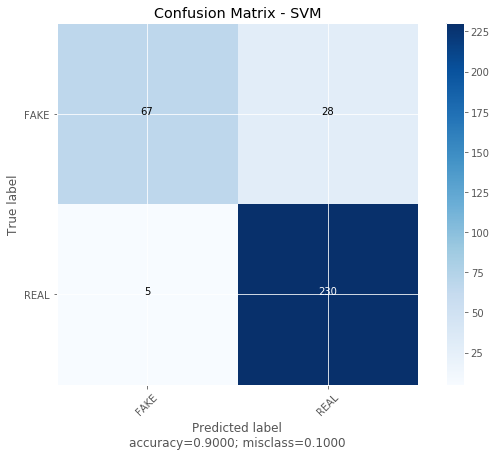

In [275]:
print('\nBest C: ', best_C)

svm_classifier = svm.SVC(kernel ='linear', C=best_C)
svm_classifier.fit(tfidf_train, y_train)
svm_pred = svm_classifier.predict(tfidf_test)
svm_cm = metrics.confusion_matrix(y_test, svm_pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')


### Using CountVectorizer (Bag-of-words)

In [276]:
count_vectorizer = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor) #turns my text into bag-of-words vectors similar to a Gensim corpus
                                                         #it also remove english stop words from the plot summaries as a 
                                                         #preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train = count_vectorizer.fit_transform(X_train) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test = count_vectorizer.transform(X_test) #Create bag-of-words vector using the same dictionary

In [277]:
print(count_vectorizer.get_feature_names())

['2', '3', '4', '5', 'abandon', 'ability', 'able', 'abuse', 'academy', 'accept', 'access', 'accompany', 'accord', 'account', 'accuse', 'achieve', 'acknowledge', 'act', 'action', 'active', 'activity', 'actually', 'add', 'addition', 'additional', 'address', 'adjust', 'administration', 'admit', 'adult', 'advance', 'advantage', 'advertise', 'advertisement', 'advocate', 'affair', 'affect', 'africa', 'african', 'afternoon', 'age', 'agency', 'agent', 'ago', 'agree', 'agreement', 'ahead', 'aid', 'aim', 'air', 'al', 'alert', 'allow', 'ally', 'alternative', 'america', 'american', 'americans', 'amid', 'analysis', 'analyst', 'andrew', 'angeles', 'animal', 'anniversary', 'announce', 'announcement', 'annual', 'answer', 'anti', 'ap', 'apartment', 'apparently', 'appeal', 'appear', 'appearance', 'application', 'apply', 'approach', 'approve', 'april', 'area', 'argue', 'argument', 'arm', 'army', 'arrest', 'arrive', 'art', 'article', 'artist', 'asia', 'aside', 'ask', 'aspect', 'asset', 'assistant', 'assoc

### Using Naive Bayes classifier - CountVectorizer

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.85455
Alpha: 0.02 Score: 0.85758
Alpha: 0.03 Score: 0.85758
Alpha: 0.04 Score: 0.85758
Alpha: 0.05 Score: 0.85758
Alpha: 0.06 Score: 0.85758
Alpha: 0.07 Score: 0.85758
Alpha: 0.08 Score: 0.85758
Alpha: 0.09 Score: 0.85758
Alpha: 0.10 Score: 0.85758
Alpha: 0.11 Score: 0.85758
Alpha: 0.12 Score: 0.85758
Alpha: 0.13 Score: 0.85758
Alpha: 0.14 Score: 0.85758
Alpha: 0.15 Score: 0.85758
Alpha: 0.16 Score: 0.85758
Alpha: 0.17 Score: 0.85758
Alpha: 0.18 Score: 0.85758
Alpha: 0.19 Score: 0.85758
Alpha: 0.20 Score: 0.85758
Alpha: 0.21 Score: 0.85758
Alpha: 0.22 Score: 0.85758
Alpha: 0.23 Score: 0.85758
Alpha: 0.24 Score: 0.85758
Alpha: 0.25 Score: 0.85758
Alpha: 0.26 Score: 0.85455
Alpha: 0.27 Score: 0.85455
Alpha: 0.28 Score: 0.85455
Alpha: 0.29 Score: 0.85455
Alpha: 0.30 Score: 0.85758
Alpha: 0.31 Score: 0.85758
Alpha: 0.32 Score: 0.85758
Alpha: 0.33 Score: 0.85758
Alpha: 0.34 Score: 0.85455
Alpha: 0.35 Score: 

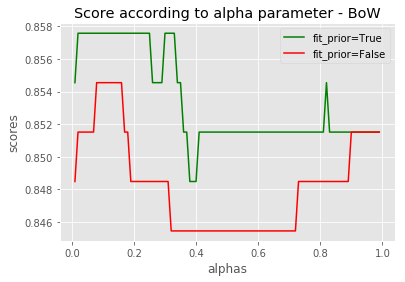

In [278]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2 = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_2.fit(count_train, y_train)
    nb_pred_2 = nb_classifier_2.predict(count_test)
    score = metrics.accuracy_score(y_test, nb_pred_2)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2 = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_2.fit(count_train, y_train)
    nb_pred_2 = nb_classifier_2.predict(count_test)
    score = metrics.accuracy_score(y_test, nb_pred_2)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - BoW')
plt.show()



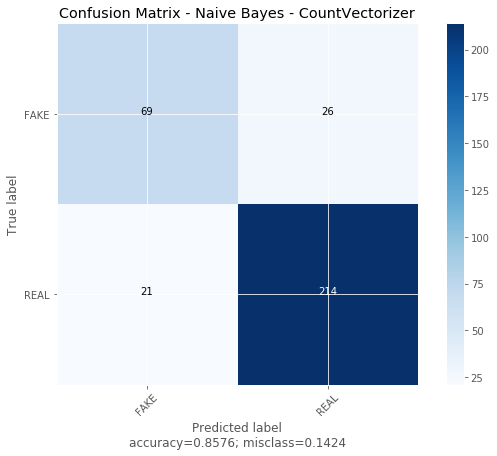

In [279]:
#best alpha = 0.1
nb_classifier_2 = MultinomialNB(alpha=best_alpha, fit_prior=fit_prior)

#this will determine the internal parameters based on the dataset.
nb_classifier_2.fit(count_train, y_train)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2 = nb_classifier_2.predict(count_test)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2 = metrics.confusion_matrix(y_test, nb_pred_2, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

C: 0.01 Score: 0.85758
C: 0.02 Score: 0.86970
C: 0.03 Score: 0.88182
C: 0.04 Score: 0.89091
C: 0.05 Score: 0.88485
C: 0.06 Score: 0.89091
C: 0.07 Score: 0.88485
C: 0.08 Score: 0.88182
C: 0.09 Score: 0.88182
C: 0.10 Score: 0.87273
C: 0.11 Score: 0.87273
C: 0.12 Score: 0.87273
C: 0.13 Score: 0.87576
C: 0.14 Score: 0.86970
C: 0.15 Score: 0.86667
C: 0.16 Score: 0.86667
C: 0.17 Score: 0.87273
C: 0.18 Score: 0.87273
C: 0.19 Score: 0.87273
C: 0.20 Score: 0.87273
C: 0.21 Score: 0.86970
C: 0.22 Score: 0.86667
C: 0.23 Score: 0.86970
C: 0.24 Score: 0.86970
C: 0.25 Score: 0.87273
C: 0.26 Score: 0.86970
C: 0.27 Score: 0.87273
C: 0.28 Score: 0.86970
C: 0.29 Score: 0.86970
C: 0.30 Score: 0.86364
C: 0.31 Score: 0.86364
C: 0.32 Score: 0.86667
C: 0.33 Score: 0.86667
C: 0.34 Score: 0.86970
C: 0.35 Score: 0.86970
C: 0.36 Score: 0.86970
C: 0.37 Score: 0.86970
C: 0.38 Score: 0.87273
C: 0.39 Score: 0.87273
C: 0.40 Score: 0.86970
C: 0.41 Score: 0.86970
C: 0.42 Score: 0.86970
C: 0.43 Score: 0.86970
C: 0.44 Sco

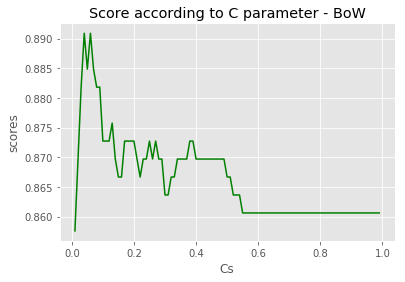

In [280]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_2 = svm.SVC(kernel ='linear', C=C)
    svm_classifier_2.fit(count_train, y_train)
    svm_pred_2 = svm_classifier_2.predict(count_test)
    score = metrics.accuracy_score(y_test, svm_pred_2)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - BoW')

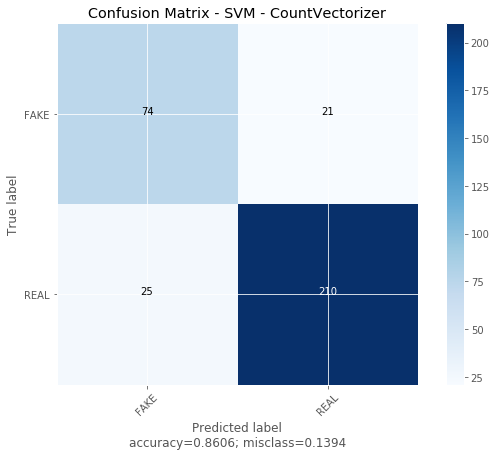

In [281]:
#best C=0.9
svm_classifier_2 = svm.SVC(kernel ='linear', C=0.9)
svm_classifier_2.fit(count_train, y_train)
svm_pred_2 = svm_classifier_2.predict(count_test)
svm_cm_2 = metrics.confusion_matrix(y_test, svm_pred_2, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [9]:
# integer encode
#transform y values ['FAKE', 'REAL'] into 0s and 1s
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train.values)
integer_encoded_test = label_encoder.fit_transform(y_test.values)
print(integer_encoded_train)

[1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0
 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1
 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 0
 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1
 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1
 0 1 1 1 0 1 0 1 1 0 0 1 

### Word Embeddings

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#return a list of sequences (one per text input)
X_2_train = tokenizer.texts_to_sequences(X_train)

X_2_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 #adding 1 because of reserved 0 index

maxlen = 0
for sequence in X_2_train:
    maxlen = maxlen + len(sequence)

for sequence in X_2_test:
    maxlen = maxlen + len(sequence)

#maxlen will be the arithmetic mean of the sum of sequences    
maxlen = round(maxlen/(len(X_2_train)+len(X_2_test)))
    



#avoid the problem that each text sequence has different length of words
X_2_train = pad_sequences(X_2_train, padding='post', maxlen=maxlen) #pads the sequence of words with zeros
X_2_test = pad_sequences(X_2_test, padding='post', maxlen=maxlen) #pads the sequence of words with zeros




### Using Convolutional Neural Network

In [317]:
def create_cnn():
    embedding_dim = round((vocab_size/maxlen))

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=maxlen))
    
    model.add(layers.Conv1D(filters=64, kernel_size=5,
                            padding='same',
                            activation='relu'))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [318]:
model = create_cnn()
#Using earling stop to see which epoch gives the better result
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_77 (Embedding)     (None, 495, 58)           1660656   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 495, 64)           18624     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 11        
Total params: 1,679,941
Trainable params: 1,679,941
Non-trainable params: 0
_________________________________________________________________


In [319]:
#trainning the model
history = model.fit(X_2_train, integer_encoded_train,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_2_test, integer_encoded_test),
                    batch_size=32, 
                    callbacks=[monitor])

Train on 670 samples, validate on 330 samples
Epoch 1/1000
670/670 [==============================] - ETA: 1:36 - loss: 0.7121 - acc: 0.375 - ETA: 12s - loss: 0.7125 - acc: 0.354 - ETA: 2s - loss: 0.7031 - acc: 0.4263 - 5s 8ms/step - loss: 0.6967 - acc: 0.4925 - val_loss: 0.6694 - val_acc: 0.7121
Epoch 2/1000
670/670 [==============================] - ETA: 0s - loss: 0.6508 - acc: 0.812 - ETA: 0s - loss: 0.6595 - acc: 0.704 - ETA: 0s - loss: 0.6548 - acc: 0.689 - 0s 277us/step - loss: 0.6478 - acc: 0.6925 - val_loss: 0.6141 - val_acc: 0.7121
Epoch 3/1000
670/670 [==============================] - ETA: 0s - loss: 0.6213 - acc: 0.625 - ETA: 0s - loss: 0.6044 - acc: 0.683 - ETA: 0s - loss: 0.6025 - acc: 0.683 - 0s 277us/step - loss: 0.5944 - acc: 0.6896 - val_loss: 0.5563 - val_acc: 0.7121
Epoch 4/1000
670/670 [==============================] - ETA: 0s - loss: 0.5881 - acc: 0.625 - ETA: 0s - loss: 0.5422 - acc: 0.711 - ETA: 0s - loss: 0.5342 - acc: 0.718 - 0s 273us/step - loss: 0.5361 - a

Training Accuracy: 1.0000
Testing Accuracy:  0.9091


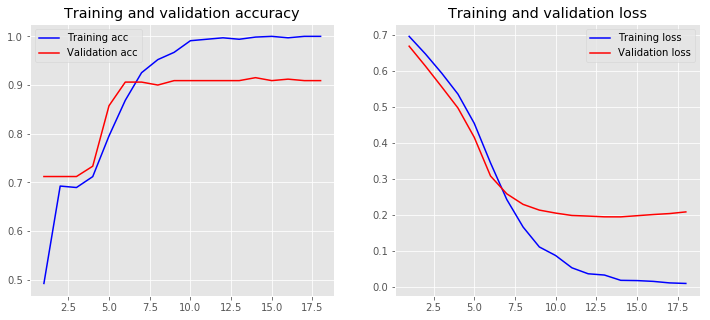

In [320]:
loss, accuracy = model.evaluate(X_2_train, integer_encoded_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_2_test, integer_encoded_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

330/330 [==============================] - ETA:  - 0s 1ms/step


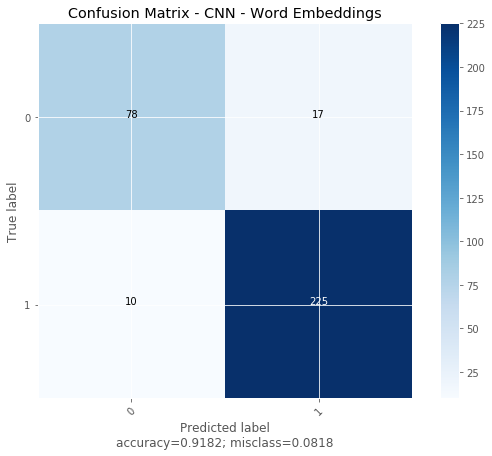

In [128]:
keras_pred = model.predict_classes(X_2_test, batch_size=32, verbose=1)
keras_cm = metrics.confusion_matrix(integer_encoded_test, keras_pred, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm, normalize=False, target_names=[0, 1], title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Long Short-Term Memory

In [439]:
def create_lstm():
    embedding_dim2 = round((vocab_size/maxlen))
    model2 = Sequential()
    model2.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim2, input_length=maxlen))
    model2.add(layers.CuDNNLSTM(64))
    model2.add(layers.Dropout(0.5))
    model2.add(layers.Dense(10, activation='relu'))
    model2.add(layers.Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model2.summary())
    return model2


In [440]:
model2 = create_lstm()
#Using earling stop to see which epoch gives the better result
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_109 (Embedding)    (None, 495, 58)           1660656   
_________________________________________________________________
cu_dnnlstm_98 (CuDNNLSTM)    (None, 64)                31744     
_________________________________________________________________
dropout_114 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_133 (Dense)            (None, 1)                 11        
Total params: 1,693,061
Trainable params: 1,693,061
Non-trainable params: 0
_________________________________________________________________
None


In [435]:
history = model2.fit(X_2_train, integer_encoded_train,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_2_test, integer_encoded_test),
                    batch_size=32,
                    callbacks=[monitor]) #batch_size >= 150 pc stops working


Train on 670 samples, validate on 330 samples
Epoch 1/1000
670/670 [==============================] - ETA: 2:09 - loss: 0.6926 - acc: 0.500 - ETA: 39s - loss: 0.6876 - acc: 0.656 - ETA: 21s - loss: 0.6859 - acc: 0.65 - ETA: 13s - loss: 0.6746 - acc: 0.68 - ETA: 9s - loss: 0.6700 - acc: 0.6944 - ETA: 6s - loss: 0.6621 - acc: 0.698 - ETA: 4s - loss: 0.6707 - acc: 0.682 - ETA: 2s - loss: 0.6678 - acc: 0.675 - ETA: 1s - loss: 0.6589 - acc: 0.683 - ETA: 0s - loss: 0.6674 - acc: 0.669 - 8s 12ms/step - loss: 0.6586 - acc: 0.6791 - val_loss: 0.6154 - val_acc: 0.7121
Epoch 2/1000
670/670 [==============================] - ETA: 0s - loss: 0.6723 - acc: 0.625 - ETA: 0s - loss: 0.6483 - acc: 0.656 - ETA: 0s - loss: 0.6141 - acc: 0.712 - ETA: 0s - loss: 0.6154 - acc: 0.709 - ETA: 0s - loss: 0.6224 - acc: 0.697 - ETA: 0s - loss: 0.6251 - acc: 0.690 - ETA: 0s - loss: 0.6210 - acc: 0.694 - ETA: 0s - loss: 0.6242 - acc: 0.687 - ETA: 0s - loss: 0.6226 - acc: 0.687 - ETA: 0s - loss: 0.6223 - acc: 0.684 -

Training Accuracy: 0.8910
Testing Accuracy:  0.8485


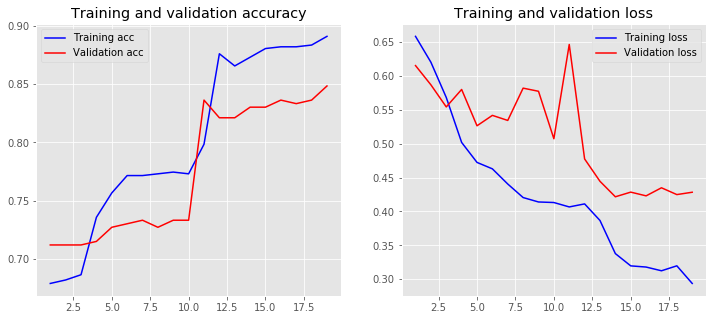

In [436]:
loss, accuracy = model2.evaluate(X_2_train, integer_encoded_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_2_test, integer_encoded_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

330/330 [==============================] - ETA: 24 - ETA: 2 - ETA:  - 3s 8ms/step


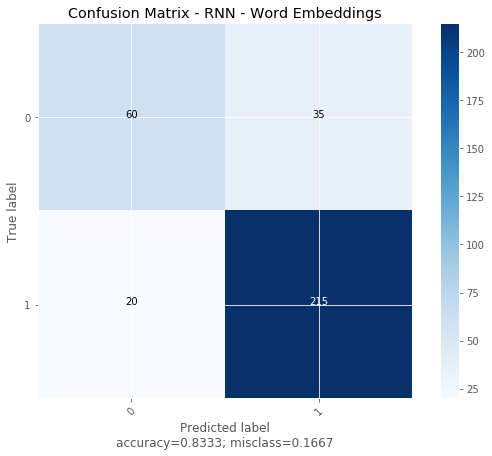

In [432]:
keras_pred2 = model2.predict_classes(X_2_test, batch_size=32, verbose=1)
keras_cm2 = metrics.confusion_matrix(integer_encoded_test, keras_pred2, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2, normalize=False, target_names=[0, 1], title = 'Confusion Matrix - RNN - Word Embeddings')

## News Cleaned - Medium (10.000 datas)

In [25]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()
stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)


# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_  if token.lemma_ != '-PRON-' else token.lower_ for token in tokens])

In [26]:
y_medium = df_news_cleaned_medium.type

#getting the training and test sets
X_train_medium, X_test_medium, y_train_medium, y_test_medium = train_test_split(df_news_cleaned_medium.content,
                                                                                y_medium, test_size =0.33, random_state=53)

### Using Tfidf

In [27]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer_medium = TfidfVectorizer(stop_words="english", min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train_medium = tfidf_vectorizer_medium.fit_transform(X_train_medium.astype('U'))

# Transform the test data: tfidf_test 
tfidf_test_medium = tfidf_vectorizer_medium.transform(X_test_medium.astype('U'))

c:\users\phelipegm\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Using Naive Bayes classifier - Tfidf

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.89091
Alpha: 0.02 Score: 0.89121
Alpha: 0.03 Score: 0.89121
Alpha: 0.04 Score: 0.89121
Alpha: 0.05 Score: 0.89152
Alpha: 0.06 Score: 0.89152
Alpha: 0.07 Score: 0.89152
Alpha: 0.08 Score: 0.89182
Alpha: 0.09 Score: 0.89182
Alpha: 0.10 Score: 0.89182
Alpha: 0.11 Score: 0.89182
Alpha: 0.12 Score: 0.89182
Alpha: 0.13 Score: 0.89182
Alpha: 0.14 Score: 0.89182
Alpha: 0.15 Score: 0.89182
Alpha: 0.16 Score: 0.89152
Alpha: 0.17 Score: 0.89061
Alpha: 0.18 Score: 0.89061
Alpha: 0.19 Score: 0.89091
Alpha: 0.20 Score: 0.89091
Alpha: 0.21 Score: 0.89091
Alpha: 0.22 Score: 0.89061
Alpha: 0.23 Score: 0.89061
Alpha: 0.24 Score: 0.89061
Alpha: 0.25 Score: 0.89061
Alpha: 0.26 Score: 0.89061
Alpha: 0.27 Score: 0.89061
Alpha: 0.28 Score: 0.89061
Alpha: 0.29 Score: 0.89091
Alpha: 0.30 Score: 0.89091
Alpha: 0.31 Score: 0.89091
Alpha: 0.32 Score: 0.89091
Alpha: 0.33 Score: 0.89091
Alpha: 0.34 Score: 0.89091
Alpha: 0.35 Score: 

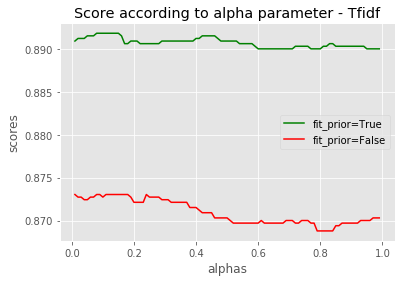

In [308]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_medium = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_medium.fit(tfidf_train_medium, y_train_medium)
    nb_pred_medium = nb_classifier_medium.predict(tfidf_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_medium)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_medium = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_medium.fit(tfidf_train_medium, y_train_medium)
    nb_pred_medium = nb_classifier_medium.predict(tfidf_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_medium)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - Tfidf')
plt.show()




Best alpha:  0.08


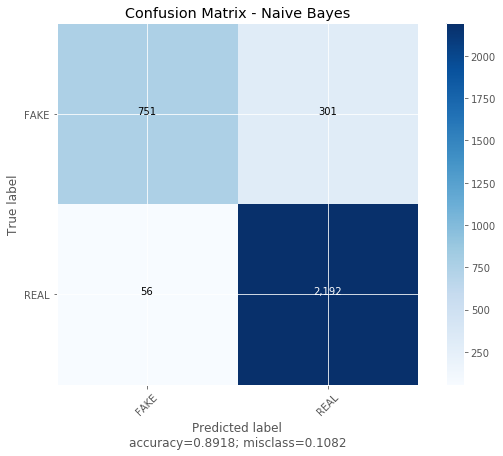

In [310]:
print('\nBest alpha: ', best_alpha)

nb_classifier_medium = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_medium.fit(tfidf_train_medium, y_train_medium)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_medium = nb_classifier_medium.predict(tfidf_test_medium)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_medium = metrics.confusion_matrix(y_test_medium, nb_pred_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_medium, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

C: 0.01 Score: 0.68394
C: 0.02 Score: 0.74333
C: 0.03 Score: 0.79909
C: 0.04 Score: 0.83606
C: 0.05 Score: 0.85909
C: 0.06 Score: 0.87424
C: 0.07 Score: 0.88697
C: 0.08 Score: 0.89515
C: 0.09 Score: 0.90212
C: 0.10 Score: 0.90758
C: 0.11 Score: 0.91152
C: 0.12 Score: 0.91242
C: 0.13 Score: 0.91333
C: 0.14 Score: 0.91455
C: 0.15 Score: 0.91515
C: 0.16 Score: 0.91818
C: 0.17 Score: 0.91909
C: 0.18 Score: 0.91909
C: 0.19 Score: 0.91970
C: 0.20 Score: 0.91939
C: 0.21 Score: 0.91939
C: 0.22 Score: 0.92000
C: 0.23 Score: 0.92030
C: 0.24 Score: 0.92061
C: 0.25 Score: 0.92091
C: 0.26 Score: 0.92182
C: 0.27 Score: 0.92242
C: 0.28 Score: 0.92394
C: 0.29 Score: 0.92394
C: 0.30 Score: 0.92273
C: 0.31 Score: 0.92242
C: 0.32 Score: 0.92152
C: 0.33 Score: 0.92182
C: 0.34 Score: 0.92212
C: 0.35 Score: 0.92182
C: 0.36 Score: 0.92212
C: 0.37 Score: 0.92182
C: 0.38 Score: 0.92273
C: 0.39 Score: 0.92303
C: 0.40 Score: 0.92364
C: 0.41 Score: 0.92333
C: 0.42 Score: 0.92333
C: 0.43 Score: 0.92394
C: 0.44 Sco

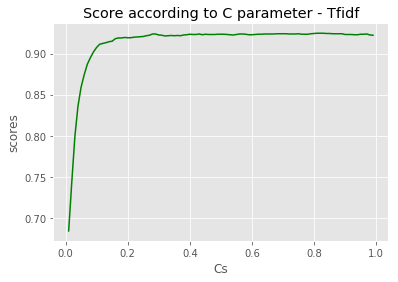

In [316]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_medium = svm.SVC(kernel ='linear', C=C)
    svm_classifier_medium.fit(tfidf_train_medium, y_train_medium)
    svm_pred_medium = svm_classifier_medium.predict(tfidf_test_medium)
    score = metrics.accuracy_score(y_test_medium, svm_pred_medium)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.81


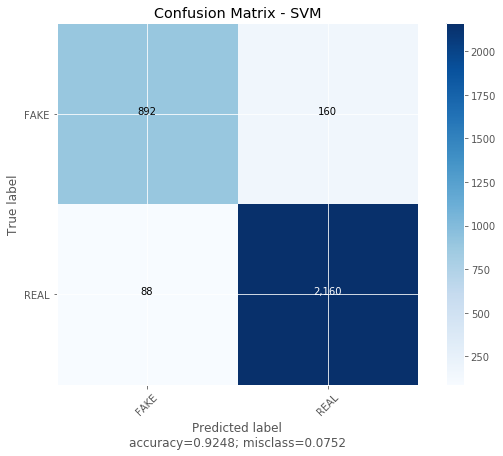

In [317]:
print('\nBest C: ', best_C)

svm_classifier_medium = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_medium.fit(tfidf_train_medium, y_train_medium)
svm_pred_medium = svm_classifier_medium.predict(tfidf_test_medium)
svm_cm_medium = metrics.confusion_matrix(y_test_medium, svm_pred_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_medium, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')

### Using CountVectorizer (Bag-of-words)

In [318]:
count_vectorizer_medium = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor) 
#turns my text into bag-of-words vectors similar to a Gensim corpus
#it also remove english stop words from the plot summaries as a 
#preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train_medium = count_vectorizer_medium.fit_transform(X_train_medium.astype('U')) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test_medium = count_vectorizer_medium.transform(X_test_medium.astype('U')) #Create bag-of-words vector using the same dictionary

### Using Naive Bayes classifier - CountVectorizer

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.86152
Alpha: 0.02 Score: 0.86152
Alpha: 0.03 Score: 0.86152
Alpha: 0.04 Score: 0.86152
Alpha: 0.05 Score: 0.86152
Alpha: 0.06 Score: 0.86152
Alpha: 0.07 Score: 0.86152
Alpha: 0.08 Score: 0.86152
Alpha: 0.09 Score: 0.86152
Alpha: 0.10 Score: 0.86152
Alpha: 0.11 Score: 0.86152
Alpha: 0.12 Score: 0.86152
Alpha: 0.13 Score: 0.86152
Alpha: 0.14 Score: 0.86152
Alpha: 0.15 Score: 0.86152
Alpha: 0.16 Score: 0.86152
Alpha: 0.17 Score: 0.86152
Alpha: 0.18 Score: 0.86152
Alpha: 0.19 Score: 0.86152
Alpha: 0.20 Score: 0.86152
Alpha: 0.21 Score: 0.86152
Alpha: 0.22 Score: 0.86152
Alpha: 0.23 Score: 0.86152
Alpha: 0.24 Score: 0.86152
Alpha: 0.25 Score: 0.86152
Alpha: 0.26 Score: 0.86152
Alpha: 0.27 Score: 0.86152
Alpha: 0.28 Score: 0.86152
Alpha: 0.29 Score: 0.86152
Alpha: 0.30 Score: 0.86152
Alpha: 0.31 Score: 0.86152
Alpha: 0.32 Score: 0.86152
Alpha: 0.33 Score: 0.86152
Alpha: 0.34 Score: 0.86152
Alpha: 0.35 Score: 

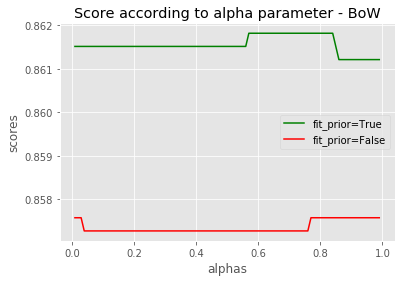

In [319]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_medium = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_2_medium.fit(count_train_medium, y_train_medium)
    nb_pred_2_medium = nb_classifier_2_medium.predict(count_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_2_medium)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_medium = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_2_medium.fit(count_train_medium, y_train_medium)
    nb_pred_2_medium = nb_classifier_2_medium.predict(count_test_medium)
    score = metrics.accuracy_score(y_test_medium, nb_pred_2_medium)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - BoW')
plt.show()




Best alpha:  0.5700000000000001


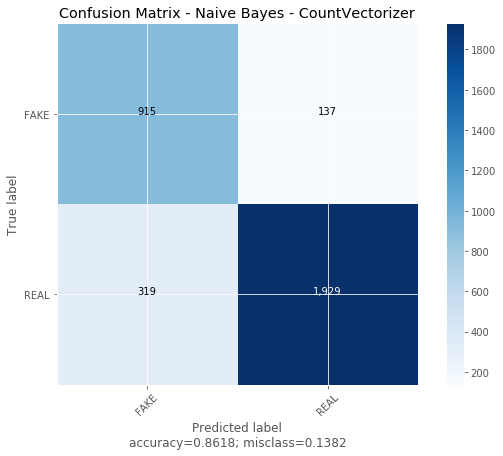

In [320]:
print('\nBest alpha: ', best_alpha)

nb_classifier_2_medium = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_2_medium.fit(count_train_medium, y_train_medium)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2_medium = nb_classifier_2_medium.predict(count_test_medium)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2_medium = metrics.confusion_matrix(y_test_medium, nb_pred_2_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2_medium, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

C: 0.01 Score: 0.91212
C: 0.02 Score: 0.90727
C: 0.03 Score: 0.90545
C: 0.04 Score: 0.90636
C: 0.05 Score: 0.90636
C: 0.06 Score: 0.90606
C: 0.07 Score: 0.90424
C: 0.08 Score: 0.90424
C: 0.09 Score: 0.90515
C: 0.10 Score: 0.90333
C: 0.11 Score: 0.90303
C: 0.12 Score: 0.90394
C: 0.13 Score: 0.90424
C: 0.14 Score: 0.90485
C: 0.15 Score: 0.90515
C: 0.16 Score: 0.90515
C: 0.17 Score: 0.90455
C: 0.18 Score: 0.90364
C: 0.19 Score: 0.90242
C: 0.20 Score: 0.90212
C: 0.21 Score: 0.90030
C: 0.22 Score: 0.90091
C: 0.23 Score: 0.89939
C: 0.24 Score: 0.89939
C: 0.25 Score: 0.89818
C: 0.26 Score: 0.89848
C: 0.27 Score: 0.89818
C: 0.28 Score: 0.89758
C: 0.29 Score: 0.89848
C: 0.30 Score: 0.90061
C: 0.31 Score: 0.90030
C: 0.32 Score: 0.89909
C: 0.33 Score: 0.89970
C: 0.34 Score: 0.89970
C: 0.35 Score: 0.89879
C: 0.36 Score: 0.89879
C: 0.37 Score: 0.89848
C: 0.38 Score: 0.89909
C: 0.39 Score: 0.89879
C: 0.40 Score: 0.89909
C: 0.41 Score: 0.89939
C: 0.42 Score: 0.89909
C: 0.43 Score: 0.89879
C: 0.44 Sco

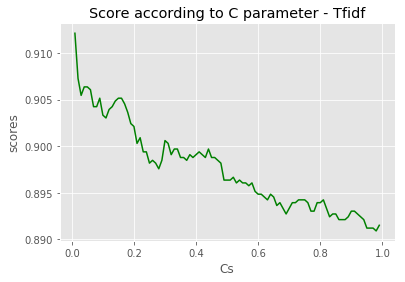

In [321]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_2_medium = svm.SVC(kernel ='linear', C=C)
    svm_classifier_2_medium.fit(count_train_medium, y_train_medium)
    svm_pred_2_medium = svm_classifier_2_medium.predict(count_test_medium)
    score = metrics.accuracy_score(y_test_medium, svm_pred_2_medium)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.01


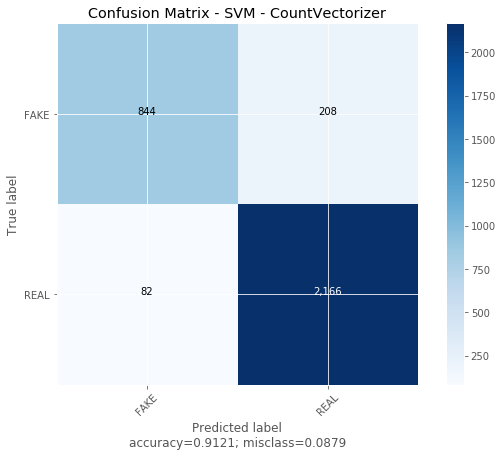

In [322]:
print('\nBest C: ', best_C)

svm_classifier_2_medium = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_2_medium.fit(count_train_medium, y_train_medium)
svm_pred_2_medium = svm_classifier_2_medium.predict(count_test_medium)
svm_cm_2_medium = metrics.confusion_matrix(y_test_medium, svm_pred_2_medium, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2_medium, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [9]:
# integer encode
#transform y values into 0s and 1s
label_encoder_medium = LabelEncoder()
integer_encoded_train_medium = label_encoder_medium.fit_transform(y_train_medium.values)
integer_encoded_test_medium = label_encoder_medium.fit_transform(y_test_medium.values)
print(integer_encoded_train_medium)

[1 1 1 ... 0 1 1]


### Word Embeddings

In [10]:
tokenizer_medium = Tokenizer()
tokenizer_medium.fit_on_texts(X_train_medium)

#return a list of sequences (one per text input)
X_2_train_medium = tokenizer_medium.texts_to_sequences(X_train_medium.astype('U'))

X_2_test_medium = tokenizer_medium.texts_to_sequences(X_test_medium.astype('U'))

vocab_size_medium = len(tokenizer_medium.word_index) + 1 #adding 1 because of reserved 0 index

maxlen_medium = 0
for sequence in X_2_train_medium:
    maxlen_medium = maxlen_medium + len(sequence)

for sequence in X_2_test_medium:
    maxlen_medium = maxlen_medium + len(sequence)

#maxlen will be the arithmetic mean of the sum of sequences    
maxlen_medium = round(maxlen_medium/(len(X_2_train_medium)+len(X_2_test_medium)))


#avoid the problem that each text sequence has different length of words
X_2_train_medium = pad_sequences(X_2_train_medium, padding='post', maxlen=maxlen_medium) #pads the sequence of words with zeros
X_2_test_medium = pad_sequences(X_2_test_medium, padding='post', maxlen=maxlen_medium) #pads the sequence of words with zeros


### Using Convolutional Neural Network

In [113]:
def create_cnn_medium():
    embedding_dim_medium = round((vocab_size_medium/maxlen_medium))

    model_medium = Sequential()
    model_medium.add(layers.Embedding(input_dim=vocab_size_medium, output_dim=embedding_dim_medium, input_length=maxlen_medium))
    model_medium.add(layers.Conv1D(128, 5, activation='relu'))
    model_medium.add(layers.GlobalMaxPool1D())
    model_medium.add(layers.Dense(10, activation='relu'))
    model_medium.add(layers.Dense(1, activation='sigmoid'))
    model_medium.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model_medium.summary()
    return model_medium

In [114]:
model_medium = create_cnn_medium()
#Using earling stop to see which epoch gives the better result
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 510, 215)          23626780  
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 506, 128)          137728    
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 11        
Total params: 23,765,809
Trainable params: 23,765,809
Non-trainable params: 0
_________________________________________________________________


In [115]:
history_medium = model_medium.fit(X_2_train_medium, integer_encoded_train_medium,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_2_test_medium, integer_encoded_test_medium),
                    batch_size=64,
                    callbacks=[monitor]) #batch_size >= 150 pc stops working

Train on 6700 samples, validate on 3300 samples
Epoch 1/1000
6700/6700 [==============================] - ETA: 2:45 - loss: 0.7411 - acc: 0.359 - ETA: 41s - loss: 0.7152 - acc: 0.402 - ETA: 23s - loss: 0.6892 - acc: 0.55 - ETA: 16s - loss: 0.6593 - acc: 0.62 - ETA: 12s - loss: 0.6451 - acc: 0.64 - ETA: 10s - loss: 0.6288 - acc: 0.65 - ETA: 8s - loss: 0.6113 - acc: 0.6735 - ETA: 7s - loss: 0.5956 - acc: 0.686 - ETA: 6s - loss: 0.5779 - acc: 0.701 - ETA: 5s - loss: 0.5635 - acc: 0.712 - ETA: 5s - loss: 0.5512 - acc: 0.721 - ETA: 4s - loss: 0.5366 - acc: 0.732 - ETA: 4s - loss: 0.5222 - acc: 0.742 - ETA: 3s - loss: 0.5065 - acc: 0.752 - ETA: 3s - loss: 0.4936 - acc: 0.759 - ETA: 3s - loss: 0.4808 - acc: 0.766 - ETA: 2s - loss: 0.4671 - acc: 0.774 - ETA: 2s - loss: 0.4531 - acc: 0.784 - ETA: 2s - loss: 0.4396 - acc: 0.792 - ETA: 2s - loss: 0.4274 - acc: 0.800 - ETA: 1s - loss: 0.4161 - acc: 0.807 - ETA: 1s - loss: 0.4071 - acc: 0.812 - ETA: 1s - loss: 0.3973 - acc: 0.817 - ETA: 1s - loss: 

Training Accuracy: 1.0000
Testing Accuracy:  0.9636


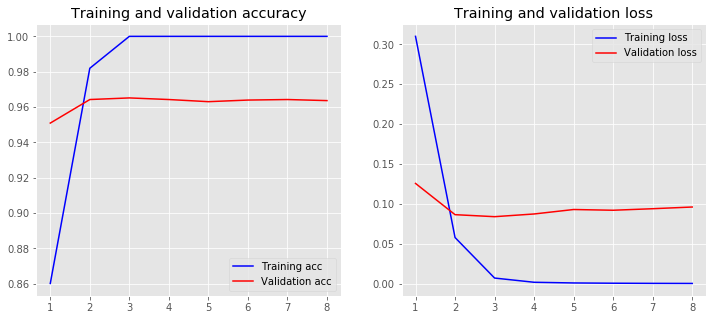

In [116]:
loss, accuracy = model_medium.evaluate(X_2_train_medium, integer_encoded_train_medium, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_medium.evaluate(X_2_test_medium, integer_encoded_test_medium, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_medium)

3300/3300 [==============================] - ETA: 22 - ETA: 1 - ETA:  - ETA:  - 1s 188us/step


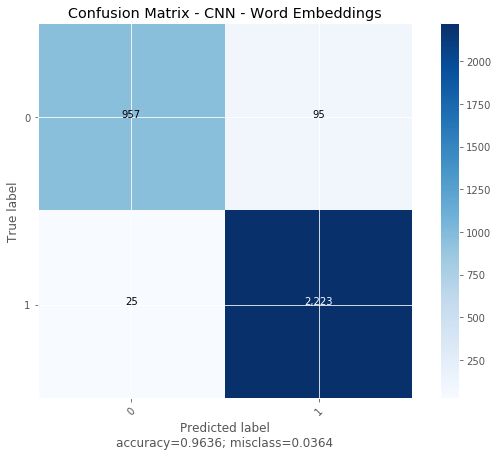

In [117]:
keras_pred_medium = model_medium.predict_classes(X_2_test_medium, batch_size=, verbose=1)
keras_cm_medium = metrics.confusion_matrix(integer_encoded_test_medium, keras_pred_medium, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm_medium, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Recurrent Neural Network

In [447]:
def create_lstm_medium():
    embedding_dim2_medium = round((vocab_size_medium/maxlen_medium))

    model2_medium = Sequential()
    model2_medium.add(layers.Embedding(input_dim=vocab_size_medium, output_dim=embedding_dim2_medium, input_length=maxlen_medium))
    model2_medium.add(layers.CuDNNLSTM(64))
    model2_medium.add(layers.Dropout(0.5))
    model2_medium.add(layers.Dense(10, activation='relu'))
    model2_medium.add(layers.Dense(1, activation='sigmoid'))
    model2_medium.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model2_medium.summary())
    return model2_medium

In [448]:
model2_medium = create_lstm_medium()
#Using earling stop to see which epoch gives the better result
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_111 (Embedding)    (None, 510, 215)          23626780  
_________________________________________________________________
cu_dnnlstm_99 (CuDNNLSTM)    (None, 64)                71936     
_________________________________________________________________
dropout_116 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 11        
Total params: 23,699,377
Trainable params: 23,699,377
Non-trainable params: 0
_________________________________________________________________
None


In [449]:
history_medium = model2_medium.fit(X_2_train_medium, integer_encoded_train_medium,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_2_test_medium, integer_encoded_test_medium),
                    batch_size=64,
                    callbacks=[monitor]) #batch_size >= 150 pc stops working


Train on 6700 samples, validate on 3300 samples
Epoch 1/1000
6700/6700 [==============================] - ETA: 11:39 - loss: 0.6908 - acc: 0.62 - ETA: 5:49 - loss: 0.6897 - acc: 0.6484 - ETA: 3:52 - loss: 0.6862 - acc: 0.666 - ETA: 2:54 - loss: 0.6837 - acc: 0.660 - ETA: 2:19 - loss: 0.6786 - acc: 0.675 - ETA: 1:55 - loss: 0.6754 - acc: 0.690 - ETA: 1:38 - loss: 0.6767 - acc: 0.678 - ETA: 1:26 - loss: 0.6820 - acc: 0.658 - ETA: 1:16 - loss: 0.6734 - acc: 0.673 - ETA: 1:08 - loss: 0.6696 - acc: 0.675 - ETA: 1:02 - loss: 0.6685 - acc: 0.676 - ETA: 56s - loss: 0.6642 - acc: 0.678 - ETA: 52s - loss: 0.6620 - acc: 0.68 - ETA: 48s - loss: 0.6611 - acc: 0.68 - ETA: 44s - loss: 0.6605 - acc: 0.68 - ETA: 41s - loss: 0.6585 - acc: 0.68 - ETA: 39s - loss: 0.6562 - acc: 0.68 - ETA: 36s - loss: 0.6584 - acc: 0.68 - ETA: 34s - loss: 0.6569 - acc: 0.68 - ETA: 32s - loss: 0.6529 - acc: 0.68 - ETA: 31s - loss: 0.6518 - acc: 0.68 - ETA: 29s - loss: 0.6548 - acc: 0.68 - ETA: 28s - loss: 0.6514 - acc: 0.6

6700/6700 [==============================] - ETA: 5s - loss: 0.5163 - acc: 0.812 - ETA: 5s - loss: 0.5201 - acc: 0.804 - ETA: 5s - loss: 0.5083 - acc: 0.802 - ETA: 5s - loss: 0.4567 - acc: 0.828 - ETA: 5s - loss: 0.4474 - acc: 0.831 - ETA: 5s - loss: 0.4215 - acc: 0.843 - ETA: 5s - loss: 0.4084 - acc: 0.852 - ETA: 5s - loss: 0.4031 - acc: 0.855 - ETA: 5s - loss: 0.3917 - acc: 0.857 - ETA: 4s - loss: 0.3800 - acc: 0.862 - ETA: 4s - loss: 0.3762 - acc: 0.865 - ETA: 4s - loss: 0.3776 - acc: 0.865 - ETA: 4s - loss: 0.3790 - acc: 0.864 - ETA: 4s - loss: 0.3813 - acc: 0.861 - ETA: 4s - loss: 0.3780 - acc: 0.864 - ETA: 4s - loss: 0.3778 - acc: 0.864 - ETA: 4s - loss: 0.3739 - acc: 0.866 - ETA: 4s - loss: 0.3727 - acc: 0.864 - ETA: 4s - loss: 0.3760 - acc: 0.861 - ETA: 4s - loss: 0.3744 - acc: 0.863 - ETA: 4s - loss: 0.3701 - acc: 0.866 - ETA: 4s - loss: 0.3690 - acc: 0.866 - ETA: 4s - loss: 0.3709 - acc: 0.866 - ETA: 4s - loss: 0.3696 - acc: 0.865 - ETA: 4s - loss: 0.3718 - acc: 0.864 - ETA: 

6700/6700 [==============================] - ETA: 4s - loss: 0.4018 - acc: 0.703 - ETA: 4s - loss: 0.3761 - acc: 0.742 - ETA: 4s - loss: 0.3632 - acc: 0.755 - ETA: 5s - loss: 0.3323 - acc: 0.785 - ETA: 5s - loss: 0.3179 - acc: 0.800 - ETA: 5s - loss: 0.3382 - acc: 0.804 - ETA: 5s - loss: 0.3224 - acc: 0.817 - ETA: 5s - loss: 0.3215 - acc: 0.816 - ETA: 5s - loss: 0.3270 - acc: 0.814 - ETA: 5s - loss: 0.3242 - acc: 0.818 - ETA: 4s - loss: 0.3255 - acc: 0.818 - ETA: 4s - loss: 0.3219 - acc: 0.821 - ETA: 4s - loss: 0.3245 - acc: 0.820 - ETA: 4s - loss: 0.3356 - acc: 0.819 - ETA: 4s - loss: 0.3394 - acc: 0.818 - ETA: 4s - loss: 0.3399 - acc: 0.817 - ETA: 4s - loss: 0.3332 - acc: 0.822 - ETA: 4s - loss: 0.3316 - acc: 0.821 - ETA: 4s - loss: 0.3277 - acc: 0.823 - ETA: 4s - loss: 0.3264 - acc: 0.822 - ETA: 4s - loss: 0.3237 - acc: 0.826 - ETA: 4s - loss: 0.3244 - acc: 0.825 - ETA: 4s - loss: 0.3222 - acc: 0.827 - ETA: 4s - loss: 0.3207 - acc: 0.829 - ETA: 4s - loss: 0.3182 - acc: 0.829 - ETA: 

6700/6700 [==============================] - ETA: 4s - loss: 0.1530 - acc: 0.953 - ETA: 5s - loss: 0.1238 - acc: 0.968 - ETA: 5s - loss: 0.1261 - acc: 0.968 - ETA: 5s - loss: 0.1349 - acc: 0.968 - ETA: 5s - loss: 0.1409 - acc: 0.962 - ETA: 5s - loss: 0.1333 - acc: 0.963 - ETA: 5s - loss: 0.1403 - acc: 0.962 - ETA: 5s - loss: 0.1674 - acc: 0.951 - ETA: 5s - loss: 0.1703 - acc: 0.947 - ETA: 5s - loss: 0.1697 - acc: 0.946 - ETA: 5s - loss: 0.1634 - acc: 0.948 - ETA: 4s - loss: 0.1609 - acc: 0.950 - ETA: 4s - loss: 0.1652 - acc: 0.949 - ETA: 4s - loss: 0.1625 - acc: 0.950 - ETA: 4s - loss: 0.1682 - acc: 0.950 - ETA: 4s - loss: 0.1631 - acc: 0.952 - ETA: 4s - loss: 0.1623 - acc: 0.952 - ETA: 4s - loss: 0.1604 - acc: 0.952 - ETA: 4s - loss: 0.1585 - acc: 0.953 - ETA: 4s - loss: 0.1614 - acc: 0.953 - ETA: 4s - loss: 0.1584 - acc: 0.954 - ETA: 4s - loss: 0.1614 - acc: 0.953 - ETA: 4s - loss: 0.1641 - acc: 0.953 - ETA: 4s - loss: 0.1639 - acc: 0.953 - ETA: 4s - loss: 0.1621 - acc: 0.953 - ETA: 

6700/6700 [==============================] - ETA: 5s - loss: 0.0527 - acc: 0.984 - ETA: 5s - loss: 0.0430 - acc: 0.992 - ETA: 5s - loss: 0.0648 - acc: 0.984 - ETA: 5s - loss: 0.0647 - acc: 0.984 - ETA: 5s - loss: 0.0732 - acc: 0.981 - ETA: 5s - loss: 0.0889 - acc: 0.976 - ETA: 5s - loss: 0.0860 - acc: 0.977 - ETA: 5s - loss: 0.0960 - acc: 0.974 - ETA: 5s - loss: 0.1029 - acc: 0.972 - ETA: 5s - loss: 0.1004 - acc: 0.973 - ETA: 5s - loss: 0.0979 - acc: 0.974 - ETA: 5s - loss: 0.0997 - acc: 0.974 - ETA: 4s - loss: 0.0980 - acc: 0.974 - ETA: 4s - loss: 0.0982 - acc: 0.974 - ETA: 4s - loss: 0.0972 - acc: 0.975 - ETA: 4s - loss: 0.0962 - acc: 0.975 - ETA: 4s - loss: 0.0954 - acc: 0.975 - ETA: 4s - loss: 0.0920 - acc: 0.977 - ETA: 4s - loss: 0.0962 - acc: 0.975 - ETA: 4s - loss: 0.0929 - acc: 0.976 - ETA: 4s - loss: 0.0945 - acc: 0.976 - ETA: 4s - loss: 0.0934 - acc: 0.976 - ETA: 4s - loss: 0.0926 - acc: 0.977 - ETA: 4s - loss: 0.0899 - acc: 0.978 - ETA: 4s - loss: 0.0886 - acc: 0.978 - ETA: 

Training Accuracy: 0.9770
Testing Accuracy:  0.9394


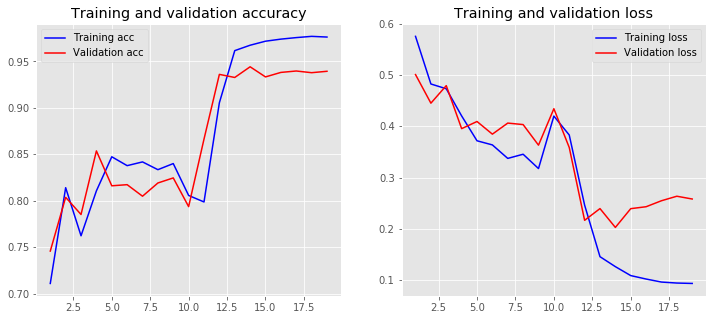

In [450]:
loss, accuracy = model2_medium.evaluate(X_2_train_medium, integer_encoded_train_medium, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2_medium.evaluate(X_2_test_medium, integer_encoded_test_medium, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_medium)

3300/3300 [==============================] - ETA: 3: - ETA: 47s - ETA: 26 - ETA: 17 - ETA: 13 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 1ms/step


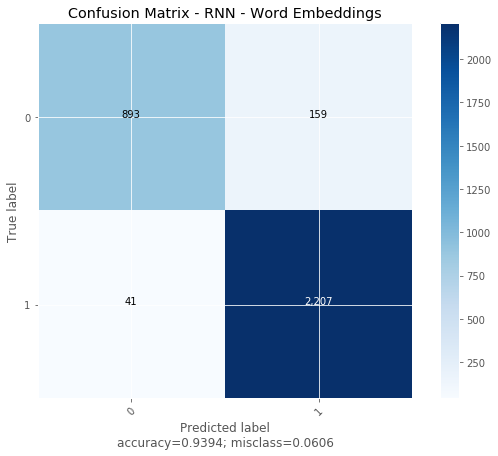

In [451]:
keras_pred2_medium = model2_medium.predict_classes(X_2_test_medium, batch_size=50, verbose=1)
keras_cm2_medium = metrics.confusion_matrix(integer_encoded_test_medium, keras_pred2_medium, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2_medium, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - RNN - Word Embeddings')

## News Cleaned - Large (100.000 datas)

## Some preprocessing

In [28]:
spacy.load('en')
lemmatizer = spacy.lang.en.English()
stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)


# remove html entities from docs and
# set everything to lowercase
def preprocessor(doc):
    return(unescape(doc).lower())
# tokenize the doc and lemmatize its tokens
def tokenizer(doc):
    tokens = lemmatizer(doc)
    #When I use this code the accuracy decreases
    tokens = [token for token in tokens if token.is_ascii and token.is_alpha]
    return([token.lemma_  if token.lemma_ != '-PRON-' else token.lower_ for token in tokens])

In [29]:
y_large = df_news_cleaned_large.type

#getting the training and test sets
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(df_news_cleaned_large.content,
                                                                                y_large, test_size =0.33, random_state=53)

### Using Tfidf

In [30]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer_large = TfidfVectorizer(stop_words="english", min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor)

# Transform the training data: tfidf_train 
tfidf_train_large = tfidf_vectorizer_large.fit_transform(X_train_large.astype('U'))

# Transform the test data: tfidf_test 
tfidf_test_large = tfidf_vectorizer_large.transform(X_test_large.astype('U'))

### Using Naive Bayes classifier - Tfidf

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.88670
Alpha: 0.02 Score: 0.88670
Alpha: 0.03 Score: 0.88670
Alpha: 0.04 Score: 0.88670
Alpha: 0.05 Score: 0.88670
Alpha: 0.06 Score: 0.88670
Alpha: 0.07 Score: 0.88670
Alpha: 0.08 Score: 0.88670
Alpha: 0.09 Score: 0.88667
Alpha: 0.10 Score: 0.88667
Alpha: 0.11 Score: 0.88667
Alpha: 0.12 Score: 0.88667
Alpha: 0.13 Score: 0.88667
Alpha: 0.14 Score: 0.88667
Alpha: 0.15 Score: 0.88670
Alpha: 0.16 Score: 0.88667
Alpha: 0.17 Score: 0.88667
Alpha: 0.18 Score: 0.88667
Alpha: 0.19 Score: 0.88667
Alpha: 0.20 Score: 0.88667
Alpha: 0.21 Score: 0.88664
Alpha: 0.22 Score: 0.88664
Alpha: 0.23 Score: 0.88664
Alpha: 0.24 Score: 0.88664
Alpha: 0.25 Score: 0.88664
Alpha: 0.26 Score: 0.88664
Alpha: 0.27 Score: 0.88664
Alpha: 0.28 Score: 0.88661
Alpha: 0.29 Score: 0.88661
Alpha: 0.30 Score: 0.88661
Alpha: 0.31 Score: 0.88661
Alpha: 0.32 Score: 0.88661
Alpha: 0.33 Score: 0.88661
Alpha: 0.34 Score: 0.88661
Alpha: 0.35 Score: 

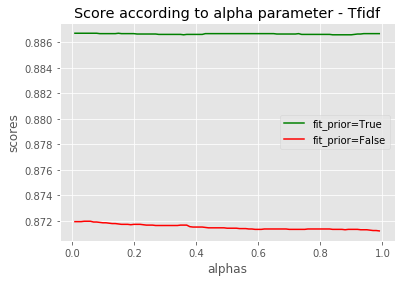

In [31]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_large = MultinomialNB(alpha=alpha,  fit_prior=True)
    nb_classifier_large.fit(tfidf_train_large, y_train_large)
    nb_pred_large = nb_classifier_large.predict(tfidf_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_large)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_large = MultinomialNB(alpha=alpha,  fit_prior=False)
    nb_classifier_large.fit(tfidf_train_large, y_train_large)
    nb_pred_large = nb_classifier_large.predict(tfidf_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_large)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - Tfidf')
plt.show()




Best alpha:  0.01


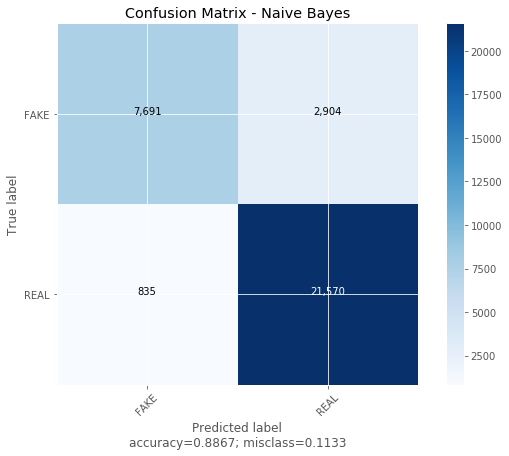

In [32]:
print('\nBest alpha: ', best_alpha)

nb_classifier_large = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_large.fit(tfidf_train_large, y_train_large)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_large = nb_classifier_large.predict(tfidf_test_large)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_large = metrics.confusion_matrix(y_test_large, nb_pred_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_large, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - Naive Bayes')

### Using SVM - Tfidf

C: 0.01 Score: 0.90339
C: 0.02 Score: 0.92155
C: 0.03 Score: 0.92591
C: 0.04 Score: 0.92797
C: 0.05 Score: 0.92967
C: 0.06 Score: 0.93100
C: 0.07 Score: 0.93267
C: 0.08 Score: 0.93300
C: 0.09 Score: 0.93373
C: 0.10 Score: 0.93394
C: 0.11 Score: 0.93467
C: 0.12 Score: 0.93527
C: 0.13 Score: 0.93548
C: 0.14 Score: 0.93579
C: 0.15 Score: 0.93624
C: 0.16 Score: 0.93642
C: 0.17 Score: 0.93673
C: 0.18 Score: 0.93673
C: 0.19 Score: 0.93670
C: 0.20 Score: 0.93685
C: 0.21 Score: 0.93697
C: 0.22 Score: 0.93712
C: 0.23 Score: 0.93715
C: 0.24 Score: 0.93721
C: 0.25 Score: 0.93730
C: 0.26 Score: 0.93727
C: 0.27 Score: 0.93739
C: 0.28 Score: 0.93770
C: 0.29 Score: 0.93785
C: 0.30 Score: 0.93800
C: 0.31 Score: 0.93803
C: 0.32 Score: 0.93806
C: 0.33 Score: 0.93827
C: 0.34 Score: 0.93852
C: 0.35 Score: 0.93818
C: 0.36 Score: 0.93815
C: 0.37 Score: 0.93821
C: 0.38 Score: 0.93815
C: 0.39 Score: 0.93824
C: 0.40 Score: 0.93836
C: 0.41 Score: 0.93861
C: 0.42 Score: 0.93867
C: 0.43 Score: 0.93906
C: 0.44 Sco

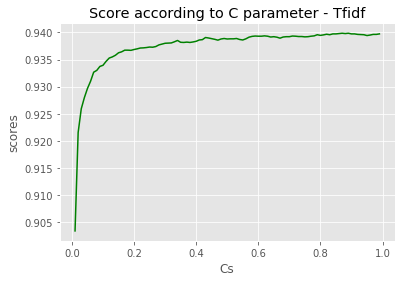

In [328]:
# TESTING PARAMETERS 1

best_C = -1
last_score = -1
Cs = []
scores = []

for C in np.arange(0.01,1,.01):
    svm_classifier_large = svm.SVC(kernel ='linear', C=C)
    svm_classifier_large.fit(tfidf_train_large, y_train_large)
    svm_pred_large = svm_classifier_large.predict(tfidf_test_large)
    score = metrics.accuracy_score(y_test_large, svm_pred_large)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - Tfidf')


Best C:  0.87


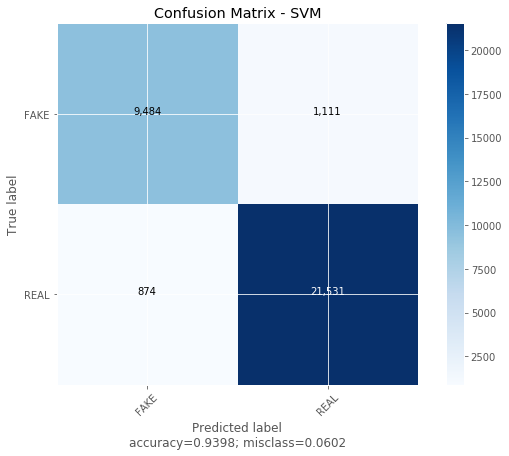

In [329]:
print('\nBest C: ', best_C)

svm_classifier_large = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_large.fit(tfidf_train_large, y_train_large)
svm_pred_large = svm_classifier_large.predict(tfidf_test_large)
svm_cm_large = metrics.confusion_matrix(y_test_large, svm_pred_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_large, normalize=False, target_names=['FAKE', 'REAL'], title = 'Confusion Matrix - SVM')

### Using CountVectorizer (Bag-of-words)

In [127]:
count_vectorizer_large = CountVectorizer(stop_words='english', min_df=0.02, max_df=0.6, tokenizer=tokenizer, preprocessor=preprocessor) 
#turns my text into bag-of-words vectors similar to a Gensim corpus
#it also remove english stop words from the plot summaries as a 
#preprocessing step
        
#Each token now acts as a feature for the machine learning classification problem, just like the flowers measurement in 
#the iris dataset

count_train_large = count_vectorizer_large.fit_transform(X_train_large.astype('U')) #Create the bag-of-words vectors
#fit_transform is a handy shortcut which will call the model's fit and then transform methods
#generates a mapping of words with IDs and vectors representing how many times each word appears in the plot
#Operates differently for each model, but generally fit will find parameters or norms in the data and transform 
#will apply the model's underlying algorithm or approximation
#For the CountVectorizer class, fit_transform will create the bag-of-words dictionary and vectors for each document using
#the training data

count_test_large = count_vectorizer_large.transform(X_test_large.astype('U')) #Create bag-of-words vector using the same dictionary

### Using Naive Bayes classifier - CountVectorizer

------------ Testing alphas with fit_prior=True---------------
Alpha: 0.01 Score: 0.85812
Alpha: 0.02 Score: 0.85812
Alpha: 0.03 Score: 0.85812
Alpha: 0.04 Score: 0.85812
Alpha: 0.05 Score: 0.85812
Alpha: 0.06 Score: 0.85812
Alpha: 0.07 Score: 0.85812
Alpha: 0.08 Score: 0.85812
Alpha: 0.09 Score: 0.85812
Alpha: 0.10 Score: 0.85812
Alpha: 0.11 Score: 0.85812
Alpha: 0.12 Score: 0.85812
Alpha: 0.13 Score: 0.85812
Alpha: 0.14 Score: 0.85812
Alpha: 0.15 Score: 0.85812
Alpha: 0.16 Score: 0.85809
Alpha: 0.17 Score: 0.85809
Alpha: 0.18 Score: 0.85809
Alpha: 0.19 Score: 0.85809
Alpha: 0.20 Score: 0.85809
Alpha: 0.21 Score: 0.85809
Alpha: 0.22 Score: 0.85809
Alpha: 0.23 Score: 0.85809
Alpha: 0.24 Score: 0.85809
Alpha: 0.25 Score: 0.85809
Alpha: 0.26 Score: 0.85809
Alpha: 0.27 Score: 0.85809
Alpha: 0.28 Score: 0.85809
Alpha: 0.29 Score: 0.85809
Alpha: 0.30 Score: 0.85809
Alpha: 0.31 Score: 0.85809
Alpha: 0.32 Score: 0.85809
Alpha: 0.33 Score: 0.85809
Alpha: 0.34 Score: 0.85809
Alpha: 0.35 Score: 

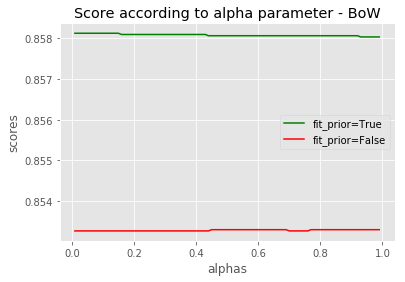

In [331]:
# TESTING PARAMETERS 1

best_alpha = -1
last_score = -1
alphas = []
scores = []
fit_prior = True
print('------------ Testing alphas with fit_prior=True---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_large = MultinomialNB(alpha=alpha, fit_prior=True)
    nb_classifier_2_large.fit(count_train_large, y_train_large)
    nb_pred_2_large = nb_classifier_2_large.predict(count_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_2_large)
    scores.append(score)
    alphas.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')    


# TESTING PARAMETERS 2

alphas2 = []
scores2 = []
print('------------ Testing alphas with fit_prior=False---------------')
for alpha in np.arange(0.01,1,.01):
    nb_classifier_2_large = MultinomialNB(alpha=alpha, fit_prior=False)
    nb_classifier_2_large.fit(count_train_large, y_train_large)
    nb_pred_2_large = nb_classifier_2_large.predict(count_test_large)
    score = metrics.accuracy_score(y_test_large, nb_pred_2_large)
    scores2.append(score)
    alphas2.append(alpha)
    if score > last_score:
        last_score = score
        best_alpha = alpha
        fit_prior = False
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))
print('--------------------------------------------------------------\n\n')  
firstplt, = plt.plot(alphas, scores, color='g', label='fit_prior=True')
secondplt, = plt.plot(alphas2, scores2, color='red', label='fit_prior=False')
plt.legend(handles=[firstplt,secondplt])
plt.xlabel('alphas')
plt.ylabel('scores')
plt.title('Score according to alpha parameter - BoW')
plt.show()




Best alpha:  0.01


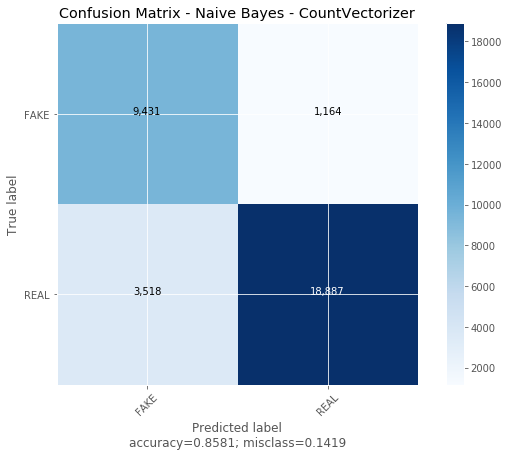

In [332]:
print('\nBest alpha: ', best_alpha)

nb_classifier_2_large = MultinomialNB(alpha=best_alpha)

#this will determine the internal parameters based on the dataset.
nb_classifier_2_large.fit(count_train_large, y_train_large)

#this will use the trained model to predict the label based on the test data vectors.
nb_pred_2_large = nb_classifier_2_large.predict(count_test_large)

#to further evaluate our model, we can also check the confusion matrix which shows correct
#and incorrect labels.
nb_cm_2_large = metrics.confusion_matrix(y_test_large, nb_pred_2_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=nb_cm_2_large, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - Naive Bayes - CountVectorizer')

### Using SVM - CountVectorizer

In [ ]:
# TESTING PARAMETERS 1

best_C = 0.03
last_score = 0.93139
Cs = []
scores = []

for C in np.arange(0.25,1,.01):
    svm_classifier_2_large = svm.SVC(kernel ='linear', C=C)
    svm_classifier_2_large.fit(count_train_large, y_train_large)
    svm_pred_2_large = svm_classifier_2_large.predict(count_test_large)
    score = metrics.accuracy_score(y_test_large, svm_pred_2_large)
    scores.append(score)
    Cs.append(C)
    if score > last_score:
        last_score = score
        best_C = C
        fit_prior = False
    print("C: {:.2f} Score: {:.5f}".format(C, score))
    
plot_line_chart(Cs, scores, 'Cs', 'scores', 'Score according to C parameter - BoW')

In [ ]:
print('\nBest C: ', best_C)

svm_classifier_2_large = svm.SVC(kernel ='linear', C=best_C)
svm_classifier_2_large.fit(count_train_large, y_train_large)
svm_pred_2_large = svm_classifier_2_large.predict(count_test_large)
svm_cm_2_large = metrics.confusion_matrix(y_test_large, svm_pred_2_large, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm=svm_cm_2_large, normalize=False, target_names=['FAKE', 'REAL'],
                      title = 'Confusion Matrix - SVM - CountVectorizer')

### Keras

In [8]:
# integer encode
#transform y values into 0s and 1s
label_encoder_large = LabelEncoder()
integer_encoded_train_large = label_encoder_large.fit_transform(y_train_large.values)
integer_encoded_test_large = label_encoder_large.fit_transform(y_test_large.values)
print(integer_encoded_train_large)
'''
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)
onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)
print(onehot_encoded_train)
'''

[1 1 0 ... 1 1 1]


'\n# binary encode\nonehot_encoder = OneHotEncoder(sparse=False)\ninteger_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)\ninteger_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)\nonehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)\nonehot_encoded_test = onehot_encoder.fit_transform(integer_encoded_test)\nprint(onehot_encoded_train)\n'

### Word Embeddings

In [9]:
tokenizer_large = Tokenizer()
tokenizer_large.fit_on_texts(X_train_large)

In [10]:
#return a list of sequences (one per text input)
X_2_train_large = tokenizer_large.texts_to_sequences(X_train_large.astype('U'))

X_2_test_large = tokenizer_large.texts_to_sequences(X_test_large.astype('U'))

In [11]:
vocab_size_large = len(tokenizer_large.word_index) + 1 #adding 1 because of reserved 0 index

In [12]:
maxlen_large = 0
for sequence in X_2_train_large:
    maxlen_large = maxlen_large + len(sequence)

for sequence in X_2_test_large:
    maxlen_large = maxlen_large + len(sequence)

#maxlen will be the arithmetic mean of the sum of sequences    
maxlen_large = round(maxlen_large/(len(X_2_train_large)+len(X_2_test_large)))

In [13]:
X_2_train_large = pad_sequences(X_2_train_large, padding='post', maxlen=maxlen_large) #pads the sequence of words with zeros

In [14]:
X_2_test_large = pad_sequences(X_2_test_large, padding='post', maxlen=maxlen_large) #pads the sequence of words with zeros

### Using Convolutional Neural Network

In [22]:
def create_cnn_large():
    embedding_dim_large = round((vocab_size_large/maxlen_large))

    model_large = Sequential()
    model_large.add(layers.Embedding(input_dim=vocab_size_large, output_dim=embedding_dim_large, input_length=maxlen_large))
    model_large.add(layers.Conv1D(128, 5, activation='relu'))
    model_large.add(layers.GlobalMaxPool1D())
    model_large.add(layers.Dense(10, activation='relu'))
    model_large.add(layers.Dense(1, activation='sigmoid'))
    model_large.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model_large.summary()
    return model_large

In [23]:
model_large = create_cnn_large()
#Using earling stop to see which epoch gives the better result
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 507, 797)          321862074 
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 503, 128)          510208    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 322,373,583
Trainable params: 322,373,583
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_large = model_large.fit(X_2_train_large, integer_encoded_train_large,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_2_test_large, integer_encoded_test_large),
                    batch_size=128,
                    callbacks=[monitor]) 

c:\users\phelipegm\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 321862074 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 67000 samples, validate on 33000 samples
Epoch 1/1000


25984/67000 [==========>...................] - ETA: 1:10:11 - loss: 0.6866 - acc: 0.66 - ETA: 35:38 - loss: 0.6751 - acc: 0.6836 - ETA: 24:04 - loss: 0.6661 - acc: 0.67 - ETA: 18:19 - loss: 0.6572 - acc: 0.67 - ETA: 14:52 - loss: 0.6418 - acc: 0.68 - ETA: 12:34 - loss: 0.6303 - acc: 0.68 - ETA: 10:55 - loss: 0.6161 - acc: 0.69 - ETA: 9:41 - loss: 0.6072 - acc: 0.6943 - ETA: 8:44 - loss: 0.6031 - acc: 0.692 - ETA: 7:58 - loss: 0.5878 - acc: 0.703 - ETA: 7:20 - loss: 0.5813 - acc: 0.700 - ETA: 6:48 - loss: 0.5691 - acc: 0.710 - ETA: 6:21 - loss: 0.5561 - acc: 0.720 - ETA: 5:58 - loss: 0.5444 - acc: 0.732 - ETA: 5:38 - loss: 0.5343 - acc: 0.738 - ETA: 5:21 - loss: 0.5250 - acc: 0.743 - ETA: 5:06 - loss: 0.5172 - acc: 0.748 - ETA: 4:52 - loss: 0.5051 - acc: 0.758 - ETA: 4:40 - loss: 0.4977 - acc: 0.761 - ETA: 4:29 - loss: 0.4893 - acc: 0.766 - ETA: 4:19 - loss: 0.4811 - acc: 0.772 - ETA: 4:09 - loss: 0.4716 - acc: 0.778 - ETA: 4:01 - loss: 0.4628 - acc: 0.785 - ETA: 3:54 - loss: 0.4534 - a

67000/67000 [==============================] - ETA: 16s - loss: 0.0937 - acc: 0.96 - ETA: 16s - loss: 0.0936 - acc: 0.96 - ETA: 16s - loss: 0.0935 - acc: 0.96 - ETA: 16s - loss: 0.0935 - acc: 0.96 - ETA: 15s - loss: 0.0933 - acc: 0.96 - ETA: 15s - loss: 0.0931 - acc: 0.96 - ETA: 15s - loss: 0.0930 - acc: 0.96 - ETA: 15s - loss: 0.0929 - acc: 0.96 - ETA: 15s - loss: 0.0928 - acc: 0.96 - ETA: 15s - loss: 0.0927 - acc: 0.96 - ETA: 14s - loss: 0.0926 - acc: 0.96 - ETA: 14s - loss: 0.0925 - acc: 0.96 - ETA: 14s - loss: 0.0923 - acc: 0.96 - ETA: 14s - loss: 0.0922 - acc: 0.96 - ETA: 14s - loss: 0.0921 - acc: 0.96 - ETA: 14s - loss: 0.0921 - acc: 0.96 - ETA: 13s - loss: 0.0920 - acc: 0.96 - ETA: 13s - loss: 0.0918 - acc: 0.96 - ETA: 13s - loss: 0.0917 - acc: 0.96 - ETA: 13s - loss: 0.0917 - acc: 0.96 - ETA: 13s - loss: 0.0915 - acc: 0.96 - ETA: 13s - loss: 0.0913 - acc: 0.96 - ETA: 12s - loss: 0.0912 - acc: 0.96 - ETA: 12s - loss: 0.0912 - acc: 0.96 - ETA: 12s - loss: 0.0911 - acc: 0.96 - ETA

26880/67000 [===========>..................] - ETA: 1:13 - loss: 0.0046 - acc: 1.000 - ETA: 1:13 - loss: 0.0196 - acc: 0.996 - ETA: 1:13 - loss: 0.0180 - acc: 0.994 - ETA: 1:13 - loss: 0.0201 - acc: 0.994 - ETA: 1:12 - loss: 0.0196 - acc: 0.995 - ETA: 1:12 - loss: 0.0240 - acc: 0.992 - ETA: 1:11 - loss: 0.0268 - acc: 0.992 - ETA: 1:11 - loss: 0.0247 - acc: 0.993 - ETA: 1:11 - loss: 0.0228 - acc: 0.993 - ETA: 1:11 - loss: 0.0219 - acc: 0.993 - ETA: 1:11 - loss: 0.0223 - acc: 0.992 - ETA: 1:11 - loss: 0.0211 - acc: 0.993 - ETA: 1:11 - loss: 0.0204 - acc: 0.993 - ETA: 1:11 - loss: 0.0216 - acc: 0.993 - ETA: 1:10 - loss: 0.0209 - acc: 0.993 - ETA: 1:10 - loss: 0.0224 - acc: 0.993 - ETA: 1:10 - loss: 0.0215 - acc: 0.993 - ETA: 1:10 - loss: 0.0214 - acc: 0.993 - ETA: 1:10 - loss: 0.0214 - acc: 0.993 - ETA: 1:10 - loss: 0.0204 - acc: 0.993 - ETA: 1:10 - loss: 0.0195 - acc: 0.994 - ETA: 1:10 - loss: 0.0188 - acc: 0.994 - ETA: 1:10 - loss: 0.0183 - acc: 0.994 - ETA: 1:09 - loss: 0.0190 - acc: 0

67000/67000 [==============================] - ETA: 13s - loss: 0.0078 - acc: 0.99 - ETA: 13s - loss: 0.0078 - acc: 0.99 - ETA: 13s - loss: 0.0078 - acc: 0.99 - ETA: 13s - loss: 0.0078 - acc: 0.99 - ETA: 13s - loss: 0.0078 - acc: 0.99 - ETA: 12s - loss: 0.0078 - acc: 0.99 - ETA: 12s - loss: 0.0078 - acc: 0.99 - ETA: 12s - loss: 0.0078 - acc: 0.99 - ETA: 12s - loss: 0.0078 - acc: 0.99 - ETA: 12s - loss: 0.0077 - acc: 0.99 - ETA: 12s - loss: 0.0077 - acc: 0.99 - ETA: 12s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 11s - loss: 0.0077 - acc: 0.99 - ETA: 10s - loss: 0.0077 - acc: 0.99 - ETA: 10s - loss: 0.0077 - acc: 0.99 - ETA: 10s - loss: 0.0076 - acc: 0.99 - ETA: 10s - loss: 0.0076 - acc: 0.99 - ETA: 10s - loss: 0.0076 - acc: 0.99 - ETA: 10s - loss: 0.0077 - acc: 0.99 - ETA

24320/67000 [=========>....................] - ETA: 1:05 - loss: 3.4275e-04 - acc: 1.000 - ETA: 1:09 - loss: 4.6799e-04 - acc: 1.000 - ETA: 1:10 - loss: 4.8285e-04 - acc: 1.000 - ETA: 1:12 - loss: 4.2765e-04 - acc: 1.000 - ETA: 1:11 - loss: 5.5975e-04 - acc: 1.000 - ETA: 1:11 - loss: 4.9203e-04 - acc: 1.000 - ETA: 1:11 - loss: 5.1461e-04 - acc: 1.000 - ETA: 1:12 - loss: 4.7983e-04 - acc: 1.000 - ETA: 1:11 - loss: 5.2396e-04 - acc: 1.000 - ETA: 1:11 - loss: 5.0305e-04 - acc: 1.000 - ETA: 1:11 - loss: 4.8742e-04 - acc: 1.000 - ETA: 1:11 - loss: 4.8020e-04 - acc: 1.000 - ETA: 1:11 - loss: 6.1007e-04 - acc: 1.000 - ETA: 1:11 - loss: 5.8342e-04 - acc: 1.000 - ETA: 1:11 - loss: 5.8551e-04 - acc: 1.000 - ETA: 1:10 - loss: 5.9329e-04 - acc: 1.000 - ETA: 1:10 - loss: 5.8729e-04 - acc: 1.000 - ETA: 1:10 - loss: 5.7430e-04 - acc: 1.000 - ETA: 1:10 - loss: 5.7524e-04 - acc: 1.000 - ETA: 1:10 - loss: 5.8824e-04 - acc: 1.000 - ETA: 1:10 - loss: 5.8203e-04 - acc: 1.000 - ETA: 1:09 - loss: 5.7978e-04 

67000/67000 [==============================] - ETA: 19s - loss: 3.5936e-04 - acc: 1.00 - ETA: 19s - loss: 3.5908e-04 - acc: 1.00 - ETA: 19s - loss: 3.5933e-04 - acc: 1.00 - ETA: 18s - loss: 3.5865e-04 - acc: 1.00 - ETA: 18s - loss: 3.5898e-04 - acc: 1.00 - ETA: 18s - loss: 3.6105e-04 - acc: 1.00 - ETA: 18s - loss: 3.6047e-04 - acc: 1.00 - ETA: 18s - loss: 3.6022e-04 - acc: 1.00 - ETA: 18s - loss: 3.6022e-04 - acc: 1.00 - ETA: 18s - loss: 3.5976e-04 - acc: 1.00 - ETA: 17s - loss: 3.6009e-04 - acc: 1.00 - ETA: 17s - loss: 3.5937e-04 - acc: 1.00 - ETA: 17s - loss: 3.5953e-04 - acc: 1.00 - ETA: 17s - loss: 3.5905e-04 - acc: 1.00 - ETA: 17s - loss: 3.5840e-04 - acc: 1.00 - ETA: 17s - loss: 3.5830e-04 - acc: 1.00 - ETA: 17s - loss: 3.5765e-04 - acc: 1.00 - ETA: 16s - loss: 3.5798e-04 - acc: 1.00 - ETA: 16s - loss: 3.5734e-04 - acc: 1.00 - ETA: 16s - loss: 3.5692e-04 - acc: 1.00 - ETA: 16s - loss: 3.5655e-04 - acc: 1.00 - ETA: 16s - loss: 3.5604e-04 - acc: 1.00 - ETA: 16s - loss: 3.5585e-04 -

24320/67000 [=========>....................] - ETA: 1:10 - loss: 7.4806e-05 - acc: 1.000 - ETA: 1:11 - loss: 7.8883e-05 - acc: 1.000 - ETA: 1:12 - loss: 7.1055e-05 - acc: 1.000 - ETA: 1:11 - loss: 6.3215e-05 - acc: 1.000 - ETA: 1:10 - loss: 6.7319e-05 - acc: 1.000 - ETA: 1:12 - loss: 8.6037e-05 - acc: 1.000 - ETA: 1:12 - loss: 1.1595e-04 - acc: 1.000 - ETA: 1:11 - loss: 1.1051e-04 - acc: 1.000 - ETA: 1:11 - loss: 1.0759e-04 - acc: 1.000 - ETA: 1:11 - loss: 1.0367e-04 - acc: 1.000 - ETA: 1:11 - loss: 9.8908e-05 - acc: 1.000 - ETA: 1:11 - loss: 9.7102e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.0698e-04 - acc: 1.000 - ETA: 1:11 - loss: 1.0533e-04 - acc: 1.000 - ETA: 1:11 - loss: 1.0412e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0076e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0156e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0305e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0822e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0603e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0988e-04 - acc: 1.000 - ETA: 1:10 - loss: 1.0788e-04 

67000/67000 [==============================] - ETA: 19s - loss: 8.2485e-05 - acc: 1.00 - ETA: 19s - loss: 8.2406e-05 - acc: 1.00 - ETA: 19s - loss: 8.2356e-05 - acc: 1.00 - ETA: 18s - loss: 8.2328e-05 - acc: 1.00 - ETA: 18s - loss: 8.2278e-05 - acc: 1.00 - ETA: 18s - loss: 8.2367e-05 - acc: 1.00 - ETA: 18s - loss: 8.2309e-05 - acc: 1.00 - ETA: 18s - loss: 8.2185e-05 - acc: 1.00 - ETA: 18s - loss: 8.2108e-05 - acc: 1.00 - ETA: 18s - loss: 8.2178e-05 - acc: 1.00 - ETA: 17s - loss: 8.2098e-05 - acc: 1.00 - ETA: 17s - loss: 8.2181e-05 - acc: 1.00 - ETA: 17s - loss: 8.2219e-05 - acc: 1.00 - ETA: 17s - loss: 8.2215e-05 - acc: 1.00 - ETA: 17s - loss: 8.2101e-05 - acc: 1.00 - ETA: 17s - loss: 8.2014e-05 - acc: 1.00 - ETA: 17s - loss: 8.1998e-05 - acc: 1.00 - ETA: 16s - loss: 8.2099e-05 - acc: 1.00 - ETA: 16s - loss: 8.2010e-05 - acc: 1.00 - ETA: 16s - loss: 8.1982e-05 - acc: 1.00 - ETA: 16s - loss: 8.1993e-05 - acc: 1.00 - ETA: 16s - loss: 8.1986e-05 - acc: 1.00 - ETA: 16s - loss: 8.2018e-05 -

24320/67000 [=========>....................] - ETA: 1:13 - loss: 4.3670e-05 - acc: 1.000 - ETA: 1:12 - loss: 7.1935e-05 - acc: 1.000 - ETA: 1:10 - loss: 5.6729e-05 - acc: 1.000 - ETA: 1:12 - loss: 5.1121e-05 - acc: 1.000 - ETA: 1:12 - loss: 4.8843e-05 - acc: 1.000 - ETA: 1:12 - loss: 4.7385e-05 - acc: 1.000 - ETA: 1:12 - loss: 4.7427e-05 - acc: 1.000 - ETA: 1:12 - loss: 4.5225e-05 - acc: 1.000 - ETA: 1:11 - loss: 4.4832e-05 - acc: 1.000 - ETA: 1:11 - loss: 4.4943e-05 - acc: 1.000 - ETA: 1:11 - loss: 4.3556e-05 - acc: 1.000 - ETA: 1:11 - loss: 4.4944e-05 - acc: 1.000 - ETA: 1:11 - loss: 4.4477e-05 - acc: 1.000 - ETA: 1:11 - loss: 4.5509e-05 - acc: 1.000 - ETA: 1:10 - loss: 4.6697e-05 - acc: 1.000 - ETA: 1:10 - loss: 4.7976e-05 - acc: 1.000 - ETA: 1:10 - loss: 4.9033e-05 - acc: 1.000 - ETA: 1:10 - loss: 4.8125e-05 - acc: 1.000 - ETA: 1:10 - loss: 4.7971e-05 - acc: 1.000 - ETA: 1:10 - loss: 4.7718e-05 - acc: 1.000 - ETA: 1:09 - loss: 4.6262e-05 - acc: 1.000 - ETA: 1:09 - loss: 4.5654e-05 

67000/67000 [==============================] - ETA: 19s - loss: 4.3421e-05 - acc: 1.00 - ETA: 19s - loss: 4.3401e-05 - acc: 1.00 - ETA: 19s - loss: 4.3427e-05 - acc: 1.00 - ETA: 18s - loss: 4.3406e-05 - acc: 1.00 - ETA: 18s - loss: 4.3350e-05 - acc: 1.00 - ETA: 18s - loss: 4.3291e-05 - acc: 1.00 - ETA: 18s - loss: 4.3286e-05 - acc: 1.00 - ETA: 18s - loss: 4.3230e-05 - acc: 1.00 - ETA: 18s - loss: 4.3256e-05 - acc: 1.00 - ETA: 18s - loss: 4.3234e-05 - acc: 1.00 - ETA: 17s - loss: 4.3188e-05 - acc: 1.00 - ETA: 17s - loss: 4.3209e-05 - acc: 1.00 - ETA: 17s - loss: 4.3174e-05 - acc: 1.00 - ETA: 17s - loss: 4.3188e-05 - acc: 1.00 - ETA: 17s - loss: 4.3155e-05 - acc: 1.00 - ETA: 17s - loss: 4.3179e-05 - acc: 1.00 - ETA: 17s - loss: 4.3230e-05 - acc: 1.00 - ETA: 16s - loss: 4.3219e-05 - acc: 1.00 - ETA: 16s - loss: 4.3246e-05 - acc: 1.00 - ETA: 16s - loss: 4.3271e-05 - acc: 1.00 - ETA: 16s - loss: 4.3267e-05 - acc: 1.00 - ETA: 16s - loss: 4.3284e-05 - acc: 1.00 - ETA: 16s - loss: 4.3280e-05 -

24320/67000 [=========>....................] - ETA: 1:13 - loss: 1.7737e-05 - acc: 1.000 - ETA: 1:13 - loss: 2.2681e-05 - acc: 1.000 - ETA: 1:13 - loss: 2.3476e-05 - acc: 1.000 - ETA: 1:13 - loss: 3.5800e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.5267e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.4360e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.2618e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.2144e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.2668e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.3315e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.4736e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.3900e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.4050e-05 - acc: 1.000 - ETA: 1:11 - loss: 3.5209e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.4440e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.4335e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.5512e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.4548e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.3998e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.3136e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.3523e-05 - acc: 1.000 - ETA: 1:10 - loss: 3.2772e-05 

67000/67000 [==============================] - ETA: 19s - loss: 2.7663e-05 - acc: 1.00 - ETA: 19s - loss: 2.7646e-05 - acc: 1.00 - ETA: 19s - loss: 2.7603e-05 - acc: 1.00 - ETA: 18s - loss: 2.7622e-05 - acc: 1.00 - ETA: 18s - loss: 2.7604e-05 - acc: 1.00 - ETA: 18s - loss: 2.7568e-05 - acc: 1.00 - ETA: 18s - loss: 2.7529e-05 - acc: 1.00 - ETA: 18s - loss: 2.7615e-05 - acc: 1.00 - ETA: 18s - loss: 2.7648e-05 - acc: 1.00 - ETA: 18s - loss: 2.7624e-05 - acc: 1.00 - ETA: 17s - loss: 2.7641e-05 - acc: 1.00 - ETA: 17s - loss: 2.7626e-05 - acc: 1.00 - ETA: 17s - loss: 2.7590e-05 - acc: 1.00 - ETA: 17s - loss: 2.7568e-05 - acc: 1.00 - ETA: 17s - loss: 2.7522e-05 - acc: 1.00 - ETA: 17s - loss: 2.7541e-05 - acc: 1.00 - ETA: 17s - loss: 2.7521e-05 - acc: 1.00 - ETA: 16s - loss: 2.7496e-05 - acc: 1.00 - ETA: 16s - loss: 2.7451e-05 - acc: 1.00 - ETA: 16s - loss: 2.7454e-05 - acc: 1.00 - ETA: 16s - loss: 2.7433e-05 - acc: 1.00 - ETA: 16s - loss: 2.7436e-05 - acc: 1.00 - ETA: 16s - loss: 2.7393e-05 -

24320/67000 [=========>....................] - ETA: 1:06 - loss: 2.1722e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.9222e-05 - acc: 1.000 - ETA: 1:12 - loss: 2.2969e-05 - acc: 1.000 - ETA: 1:11 - loss: 2.1367e-05 - acc: 1.000 - ETA: 1:12 - loss: 1.8526e-05 - acc: 1.000 - ETA: 1:12 - loss: 1.8628e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.8146e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.9118e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.9378e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.9815e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.8787e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.8180e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.9416e-05 - acc: 1.000 - ETA: 1:11 - loss: 1.8721e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.9126e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.9834e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.9712e-05 - acc: 1.000 - ETA: 1:10 - loss: 1.9990e-05 - acc: 1.000 - ETA: 1:10 - loss: 2.0154e-05 - acc: 1.000 - ETA: 1:10 - loss: 2.0672e-05 - acc: 1.000 - ETA: 1:09 - loss: 2.0669e-05 - acc: 1.000 - ETA: 1:09 - loss: 2.0745e-05 

67000/67000 [==============================] - ETA: 19s - loss: 1.8818e-05 - acc: 1.00 - ETA: 19s - loss: 1.8834e-05 - acc: 1.00 - ETA: 19s - loss: 1.8813e-05 - acc: 1.00 - ETA: 18s - loss: 1.8792e-05 - acc: 1.00 - ETA: 18s - loss: 1.8783e-05 - acc: 1.00 - ETA: 18s - loss: 1.8782e-05 - acc: 1.00 - ETA: 18s - loss: 1.8752e-05 - acc: 1.00 - ETA: 18s - loss: 1.8755e-05 - acc: 1.00 - ETA: 18s - loss: 1.8724e-05 - acc: 1.00 - ETA: 18s - loss: 1.8763e-05 - acc: 1.00 - ETA: 17s - loss: 1.8820e-05 - acc: 1.00 - ETA: 17s - loss: 1.8835e-05 - acc: 1.00 - ETA: 17s - loss: 1.8806e-05 - acc: 1.00 - ETA: 17s - loss: 1.8803e-05 - acc: 1.00 - ETA: 17s - loss: 1.8796e-05 - acc: 1.00 - ETA: 17s - loss: 1.8771e-05 - acc: 1.00 - ETA: 17s - loss: 1.8759e-05 - acc: 1.00 - ETA: 16s - loss: 1.8773e-05 - acc: 1.00 - ETA: 16s - loss: 1.8774e-05 - acc: 1.00 - ETA: 16s - loss: 1.8781e-05 - acc: 1.00 - ETA: 16s - loss: 1.8764e-05 - acc: 1.00 - ETA: 16s - loss: 1.8749e-05 - acc: 1.00 - ETA: 16s - loss: 1.8735e-05 -

Training Accuracy: 1.0000
Testing Accuracy:  0.9854


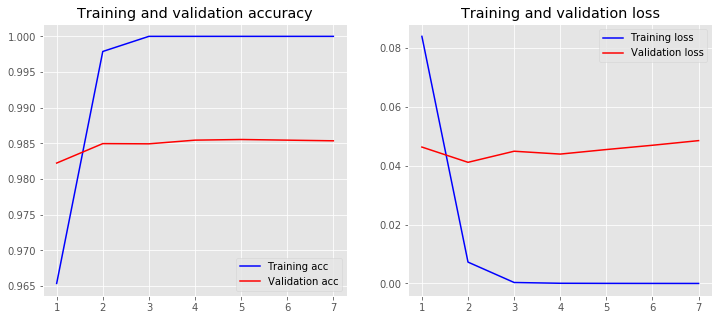

In [27]:
loss, accuracy = model_large.evaluate(X_2_train_large, integer_encoded_train_large, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_large.evaluate(X_2_test_large, integer_encoded_test_large, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_large)

33000/33000 [==============================] - ETA: 29 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 113us/step


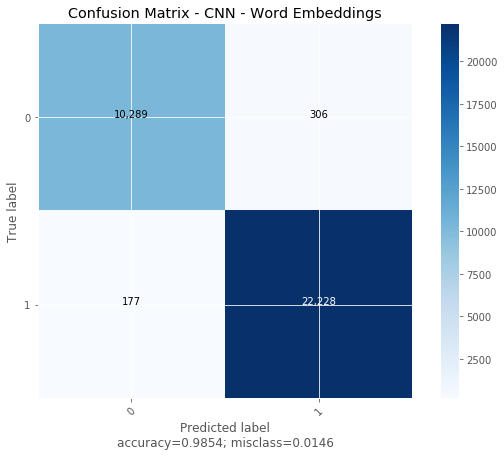

In [28]:
keras_pred_large = model_large.predict_classes(X_2_test_large, batch_size=50, verbose=1)
keras_cm_large = metrics.confusion_matrix(integer_encoded_test_large, keras_pred_large, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm_large, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - CNN - Word Embeddings')

### Using Long Short-Term Memory

In [15]:
def create_lstm_large():
    embedding_dim2_large = round((vocab_size_large/maxlen_large))

    model2_large = Sequential()
    model2_large.add(layers.Embedding(input_dim=vocab_size_large, output_dim=embedding_dim2_large, input_length=maxlen_large))
    model2_large.add(layers.CuDNNLSTM(64))
    model2_large.add(layers.Dropout(0.5))
    model2_large.add(layers.Dense(10, activation='relu'))
    model2_large.add(layers.Dense(1, activation='sigmoid'))
    model2_large.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model2_large.summary())
    return model2_large

In [16]:
model2_large = create_lstm_large()
#Using earling stop to see which epoch gives the better result
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 507, 797)          321862074 
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 64)                220928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 322,083,663
Trainable params: 322,083,663
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history_large = model2_large.fit(X_2_train_large, integer_encoded_train_large,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_2_test_large, integer_encoded_test_large),
                    batch_size=128,
                    callbacks = [monitor]) #batch_size >= 150 pc stops working


c:\users\phelipegm\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 321862074 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 67000 samples, validate on 33000 samples
Epoch 1/1000


25856/67000 [==========>...................] - ETA: 1:08:32 - loss: 0.6966 - acc: 0.46 - ETA: 34:56 - loss: 0.6902 - acc: 0.5703 - ETA: 23:42 - loss: 0.6837 - acc: 0.60 - ETA: 18:05 - loss: 0.6799 - acc: 0.63 - ETA: 14:44 - loss: 0.6794 - acc: 0.63 - ETA: 12:28 - loss: 0.6796 - acc: 0.64 - ETA: 10:53 - loss: 0.6754 - acc: 0.65 - ETA: 9:40 - loss: 0.6698 - acc: 0.6621 - ETA: 8:44 - loss: 0.6699 - acc: 0.665 - ETA: 7:59 - loss: 0.6677 - acc: 0.668 - ETA: 7:22 - loss: 0.6641 - acc: 0.676 - ETA: 6:52 - loss: 0.6573 - acc: 0.684 - ETA: 6:25 - loss: 0.6580 - acc: 0.683 - ETA: 6:03 - loss: 0.6572 - acc: 0.685 - ETA: 5:44 - loss: 0.6573 - acc: 0.683 - ETA: 5:26 - loss: 0.6529 - acc: 0.689 - ETA: 5:11 - loss: 0.6481 - acc: 0.695 - ETA: 4:58 - loss: 0.6491 - acc: 0.693 - ETA: 4:46 - loss: 0.6497 - acc: 0.692 - ETA: 4:35 - loss: 0.6485 - acc: 0.693 - ETA: 4:26 - loss: 0.6477 - acc: 0.693 - ETA: 4:17 - loss: 0.6468 - acc: 0.693 - ETA: 4:08 - loss: 0.6438 - acc: 0.696 - ETA: 4:01 - loss: 0.6420 - a

53248/67000 [======================>.......] - ETA: 1:04 - loss: 0.4834 - acc: 0.784 - ETA: 1:04 - loss: 0.4831 - acc: 0.784 - ETA: 1:04 - loss: 0.4829 - acc: 0.784 - ETA: 1:03 - loss: 0.4824 - acc: 0.784 - ETA: 1:03 - loss: 0.4816 - acc: 0.785 - ETA: 1:03 - loss: 0.4811 - acc: 0.785 - ETA: 1:02 - loss: 0.4808 - acc: 0.786 - ETA: 1:02 - loss: 0.4802 - acc: 0.786 - ETA: 1:02 - loss: 0.4794 - acc: 0.786 - ETA: 1:02 - loss: 0.4785 - acc: 0.787 - ETA: 1:01 - loss: 0.4779 - acc: 0.787 - ETA: 1:01 - loss: 0.4775 - acc: 0.788 - ETA: 1:01 - loss: 0.4770 - acc: 0.788 - ETA: 1:01 - loss: 0.4765 - acc: 0.788 - ETA: 1:01 - loss: 0.4759 - acc: 0.789 - ETA: 1:00 - loss: 0.4756 - acc: 0.789 - ETA: 1:00 - loss: 0.4754 - acc: 0.789 - ETA: 1:00 - loss: 0.4745 - acc: 0.790 - ETA: 1:00 - loss: 0.4735 - acc: 0.791 - ETA: 59s - loss: 0.4729 - acc: 0.791 - ETA: 59s - loss: 0.4728 - acc: 0.79 - ETA: 59s - loss: 0.4722 - acc: 0.79 - ETA: 59s - loss: 0.4719 - acc: 0.79 - ETA: 58s - loss: 0.4714 - acc: 0.79 - ET

67000/67000 [==============================] - ETA: 19s - loss: 0.4089 - acc: 0.83 - ETA: 19s - loss: 0.4087 - acc: 0.83 - ETA: 19s - loss: 0.4085 - acc: 0.83 - ETA: 18s - loss: 0.4082 - acc: 0.83 - ETA: 18s - loss: 0.4078 - acc: 0.83 - ETA: 18s - loss: 0.4076 - acc: 0.83 - ETA: 18s - loss: 0.4076 - acc: 0.83 - ETA: 18s - loss: 0.4075 - acc: 0.83 - ETA: 17s - loss: 0.4073 - acc: 0.83 - ETA: 17s - loss: 0.4071 - acc: 0.83 - ETA: 17s - loss: 0.4068 - acc: 0.83 - ETA: 17s - loss: 0.4067 - acc: 0.83 - ETA: 17s - loss: 0.4067 - acc: 0.83 - ETA: 16s - loss: 0.4064 - acc: 0.83 - ETA: 16s - loss: 0.4062 - acc: 0.83 - ETA: 16s - loss: 0.4060 - acc: 0.83 - ETA: 16s - loss: 0.4058 - acc: 0.83 - ETA: 16s - loss: 0.4055 - acc: 0.83 - ETA: 16s - loss: 0.4052 - acc: 0.83 - ETA: 15s - loss: 0.4052 - acc: 0.83 - ETA: 15s - loss: 0.4049 - acc: 0.83 - ETA: 15s - loss: 0.4046 - acc: 0.83 - ETA: 15s - loss: 0.4045 - acc: 0.83 - ETA: 15s - loss: 0.4043 - acc: 0.83 - ETA: 14s - loss: 0.4040 - acc: 0.83 - ETA

26496/67000 [==========>...................] - ETA: 1:29 - loss: 0.3242 - acc: 0.875 - ETA: 1:25 - loss: 0.2685 - acc: 0.902 - ETA: 1:26 - loss: 0.2688 - acc: 0.901 - ETA: 1:26 - loss: 0.2901 - acc: 0.890 - ETA: 1:24 - loss: 0.2850 - acc: 0.890 - ETA: 1:24 - loss: 0.2756 - acc: 0.897 - ETA: 1:24 - loss: 0.2732 - acc: 0.899 - ETA: 1:24 - loss: 0.2780 - acc: 0.898 - ETA: 1:23 - loss: 0.2840 - acc: 0.895 - ETA: 1:24 - loss: 0.2902 - acc: 0.892 - ETA: 1:23 - loss: 0.2882 - acc: 0.893 - ETA: 1:23 - loss: 0.2901 - acc: 0.891 - ETA: 1:23 - loss: 0.2889 - acc: 0.893 - ETA: 1:23 - loss: 0.2893 - acc: 0.892 - ETA: 1:23 - loss: 0.2975 - acc: 0.889 - ETA: 1:23 - loss: 0.2988 - acc: 0.887 - ETA: 1:22 - loss: 0.3020 - acc: 0.886 - ETA: 1:22 - loss: 0.3015 - acc: 0.886 - ETA: 1:22 - loss: 0.2988 - acc: 0.887 - ETA: 1:22 - loss: 0.2937 - acc: 0.890 - ETA: 1:22 - loss: 0.2930 - acc: 0.890 - ETA: 1:22 - loss: 0.2934 - acc: 0.891 - ETA: 1:21 - loss: 0.2885 - acc: 0.893 - ETA: 1:21 - loss: 0.2850 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.3064 - acc: 0.88 - ETA: 51s - loss: 0.3070 - acc: 0.88 - ETA: 51s - loss: 0.3078 - acc: 0.88 - ETA: 51s - loss: 0.3084 - acc: 0.88 - ETA: 51s - loss: 0.3093 - acc: 0.88 - ETA: 51s - loss: 0.3096 - acc: 0.88 - ETA: 50s - loss: 0.3105 - acc: 0.88 - ETA: 50s - loss: 0.3114 - acc: 0.88 - ETA: 50s - loss: 0.3121 - acc: 0.88 - ETA: 50s - loss: 0.3125 - acc: 0.88 - ETA: 50s - loss: 0.3132 - acc: 0.88 - ETA: 50s - loss: 0.3138 - acc: 0.88 - ETA: 49s - loss: 0.3144 - acc: 0.87 - ETA: 49s - loss: 0.3152 - acc: 0.87 - ETA: 49s - loss: 0.3161 - acc: 0.87 - ETA: 49s - loss: 0.3166 - acc: 0.87 - ETA: 49s - loss: 0.3172 - acc: 0.87 - ETA: 49s - loss: 0.3177 - acc: 0.87 - ETA: 48s - loss: 0.3186 - acc: 0.87 - ETA: 48s - loss: 0.3189 - acc: 0.87 - ETA: 48s - loss: 0.3195 - acc: 0.87 - ETA: 48s - loss: 0.3201 - acc: 0.87 - ETA: 48s - loss: 0.3208 - acc: 0.87 - ETA: 48s - loss: 0.3214 - acc: 0.87 - ETA: 47s - loss: 0.3221 - acc: 0.87 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.3256 - acc: 0.87 - ETA: 16s - loss: 0.3255 - acc: 0.87 - ETA: 16s - loss: 0.3254 - acc: 0.87 - ETA: 15s - loss: 0.3253 - acc: 0.87 - ETA: 15s - loss: 0.3253 - acc: 0.87 - ETA: 15s - loss: 0.3252 - acc: 0.87 - ETA: 15s - loss: 0.3254 - acc: 0.87 - ETA: 15s - loss: 0.3253 - acc: 0.87 - ETA: 15s - loss: 0.3255 - acc: 0.87 - ETA: 15s - loss: 0.3257 - acc: 0.87 - ETA: 14s - loss: 0.3258 - acc: 0.87 - ETA: 14s - loss: 0.3259 - acc: 0.87 - ETA: 14s - loss: 0.3259 - acc: 0.87 - ETA: 14s - loss: 0.3258 - acc: 0.87 - ETA: 14s - loss: 0.3258 - acc: 0.87 - ETA: 14s - loss: 0.3261 - acc: 0.87 - ETA: 13s - loss: 0.3263 - acc: 0.87 - ETA: 13s - loss: 0.3267 - acc: 0.87 - ETA: 13s - loss: 0.3266 - acc: 0.87 - ETA: 13s - loss: 0.3268 - acc: 0.87 - ETA: 13s - loss: 0.3267 - acc: 0.87 - ETA: 13s - loss: 0.3268 - acc: 0.87 - ETA: 12s - loss: 0.3267 - acc: 0.87 - ETA: 12s - loss: 0.3270 - acc: 0.87 - ETA: 12s - loss: 0.3269 - acc: 0.87 - ETA

26496/67000 [==========>...................] - ETA: 1:29 - loss: 0.2138 - acc: 0.937 - ETA: 1:25 - loss: 0.2664 - acc: 0.914 - ETA: 1:24 - loss: 0.2646 - acc: 0.914 - ETA: 1:25 - loss: 0.2617 - acc: 0.916 - ETA: 1:24 - loss: 0.2634 - acc: 0.914 - ETA: 1:24 - loss: 0.2698 - acc: 0.911 - ETA: 1:24 - loss: 0.2721 - acc: 0.910 - ETA: 1:23 - loss: 0.2661 - acc: 0.913 - ETA: 1:23 - loss: 0.2712 - acc: 0.910 - ETA: 1:23 - loss: 0.2679 - acc: 0.911 - ETA: 1:23 - loss: 0.2668 - acc: 0.912 - ETA: 1:23 - loss: 0.2660 - acc: 0.912 - ETA: 1:23 - loss: 0.2671 - acc: 0.912 - ETA: 1:23 - loss: 0.2651 - acc: 0.914 - ETA: 1:23 - loss: 0.2631 - acc: 0.914 - ETA: 1:23 - loss: 0.2620 - acc: 0.914 - ETA: 1:22 - loss: 0.2588 - acc: 0.915 - ETA: 1:22 - loss: 0.2591 - acc: 0.916 - ETA: 1:22 - loss: 0.2631 - acc: 0.914 - ETA: 1:22 - loss: 0.2610 - acc: 0.914 - ETA: 1:22 - loss: 0.2590 - acc: 0.915 - ETA: 1:21 - loss: 0.2592 - acc: 0.915 - ETA: 1:21 - loss: 0.2588 - acc: 0.915 - ETA: 1:21 - loss: 0.2582 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.2606 - acc: 0.91 - ETA: 51s - loss: 0.2603 - acc: 0.91 - ETA: 51s - loss: 0.2603 - acc: 0.91 - ETA: 51s - loss: 0.2603 - acc: 0.91 - ETA: 51s - loss: 0.2603 - acc: 0.91 - ETA: 51s - loss: 0.2602 - acc: 0.91 - ETA: 50s - loss: 0.2600 - acc: 0.91 - ETA: 50s - loss: 0.2595 - acc: 0.91 - ETA: 50s - loss: 0.2594 - acc: 0.91 - ETA: 50s - loss: 0.2591 - acc: 0.91 - ETA: 50s - loss: 0.2588 - acc: 0.91 - ETA: 50s - loss: 0.2589 - acc: 0.91 - ETA: 49s - loss: 0.2585 - acc: 0.91 - ETA: 49s - loss: 0.2586 - acc: 0.91 - ETA: 49s - loss: 0.2588 - acc: 0.91 - ETA: 49s - loss: 0.2592 - acc: 0.91 - ETA: 49s - loss: 0.2590 - acc: 0.91 - ETA: 49s - loss: 0.2588 - acc: 0.91 - ETA: 48s - loss: 0.2584 - acc: 0.91 - ETA: 48s - loss: 0.2580 - acc: 0.91 - ETA: 48s - loss: 0.2579 - acc: 0.91 - ETA: 48s - loss: 0.2576 - acc: 0.91 - ETA: 48s - loss: 0.2572 - acc: 0.91 - ETA: 48s - loss: 0.2570 - acc: 0.91 - ETA: 47s - loss: 0.2566 - acc: 0.91 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.2478 - acc: 0.91 - ETA: 16s - loss: 0.2479 - acc: 0.91 - ETA: 16s - loss: 0.2477 - acc: 0.91 - ETA: 16s - loss: 0.2477 - acc: 0.91 - ETA: 15s - loss: 0.2477 - acc: 0.91 - ETA: 15s - loss: 0.2479 - acc: 0.91 - ETA: 15s - loss: 0.2478 - acc: 0.91 - ETA: 15s - loss: 0.2479 - acc: 0.91 - ETA: 15s - loss: 0.2480 - acc: 0.91 - ETA: 15s - loss: 0.2480 - acc: 0.91 - ETA: 14s - loss: 0.2480 - acc: 0.91 - ETA: 14s - loss: 0.2481 - acc: 0.91 - ETA: 14s - loss: 0.2480 - acc: 0.91 - ETA: 14s - loss: 0.2480 - acc: 0.91 - ETA: 14s - loss: 0.2481 - acc: 0.91 - ETA: 14s - loss: 0.2480 - acc: 0.91 - ETA: 13s - loss: 0.2480 - acc: 0.91 - ETA: 13s - loss: 0.2480 - acc: 0.91 - ETA: 13s - loss: 0.2480 - acc: 0.91 - ETA: 13s - loss: 0.2483 - acc: 0.91 - ETA: 13s - loss: 0.2483 - acc: 0.91 - ETA: 13s - loss: 0.2485 - acc: 0.91 - ETA: 12s - loss: 0.2485 - acc: 0.91 - ETA: 12s - loss: 0.2487 - acc: 0.91 - ETA: 12s - loss: 0.2487 - acc: 0.91 - ETA

26496/67000 [==========>...................] - ETA: 1:29 - loss: 0.1631 - acc: 0.953 - ETA: 1:25 - loss: 0.1594 - acc: 0.953 - ETA: 1:26 - loss: 0.1814 - acc: 0.945 - ETA: 1:25 - loss: 0.1823 - acc: 0.943 - ETA: 1:26 - loss: 0.2089 - acc: 0.929 - ETA: 1:24 - loss: 0.2105 - acc: 0.927 - ETA: 1:25 - loss: 0.2146 - acc: 0.926 - ETA: 1:24 - loss: 0.2220 - acc: 0.922 - ETA: 1:24 - loss: 0.2224 - acc: 0.921 - ETA: 1:24 - loss: 0.2250 - acc: 0.919 - ETA: 1:24 - loss: 0.2355 - acc: 0.914 - ETA: 1:23 - loss: 0.2354 - acc: 0.914 - ETA: 1:24 - loss: 0.2341 - acc: 0.914 - ETA: 1:23 - loss: 0.2382 - acc: 0.912 - ETA: 1:23 - loss: 0.2396 - acc: 0.912 - ETA: 1:23 - loss: 0.2411 - acc: 0.911 - ETA: 1:23 - loss: 0.2396 - acc: 0.912 - ETA: 1:22 - loss: 0.2413 - acc: 0.911 - ETA: 1:22 - loss: 0.2387 - acc: 0.912 - ETA: 1:22 - loss: 0.2403 - acc: 0.912 - ETA: 1:22 - loss: 0.2417 - acc: 0.911 - ETA: 1:22 - loss: 0.2411 - acc: 0.911 - ETA: 1:22 - loss: 0.2417 - acc: 0.910 - ETA: 1:21 - loss: 0.2429 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.2167 - acc: 0.92 - ETA: 51s - loss: 0.2168 - acc: 0.92 - ETA: 51s - loss: 0.2167 - acc: 0.92 - ETA: 51s - loss: 0.2166 - acc: 0.92 - ETA: 51s - loss: 0.2164 - acc: 0.92 - ETA: 50s - loss: 0.2165 - acc: 0.92 - ETA: 50s - loss: 0.2166 - acc: 0.92 - ETA: 50s - loss: 0.2169 - acc: 0.92 - ETA: 50s - loss: 0.2164 - acc: 0.92 - ETA: 50s - loss: 0.2162 - acc: 0.92 - ETA: 50s - loss: 0.2157 - acc: 0.92 - ETA: 49s - loss: 0.2155 - acc: 0.92 - ETA: 49s - loss: 0.2152 - acc: 0.92 - ETA: 49s - loss: 0.2153 - acc: 0.92 - ETA: 49s - loss: 0.2151 - acc: 0.92 - ETA: 49s - loss: 0.2150 - acc: 0.92 - ETA: 49s - loss: 0.2152 - acc: 0.92 - ETA: 48s - loss: 0.2151 - acc: 0.92 - ETA: 48s - loss: 0.2149 - acc: 0.92 - ETA: 48s - loss: 0.2152 - acc: 0.92 - ETA: 48s - loss: 0.2151 - acc: 0.92 - ETA: 48s - loss: 0.2151 - acc: 0.92 - ETA: 48s - loss: 0.2153 - acc: 0.92 - ETA: 47s - loss: 0.2154 - acc: 0.92 - ETA: 47s - loss: 0.2155 - acc: 0.92 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.2126 - acc: 0.92 - ETA: 16s - loss: 0.2125 - acc: 0.92 - ETA: 16s - loss: 0.2128 - acc: 0.92 - ETA: 15s - loss: 0.2128 - acc: 0.92 - ETA: 15s - loss: 0.2129 - acc: 0.92 - ETA: 15s - loss: 0.2130 - acc: 0.92 - ETA: 15s - loss: 0.2132 - acc: 0.92 - ETA: 15s - loss: 0.2131 - acc: 0.92 - ETA: 15s - loss: 0.2131 - acc: 0.92 - ETA: 14s - loss: 0.2129 - acc: 0.92 - ETA: 14s - loss: 0.2128 - acc: 0.92 - ETA: 14s - loss: 0.2127 - acc: 0.92 - ETA: 14s - loss: 0.2126 - acc: 0.92 - ETA: 14s - loss: 0.2125 - acc: 0.92 - ETA: 14s - loss: 0.2123 - acc: 0.92 - ETA: 14s - loss: 0.2123 - acc: 0.92 - ETA: 13s - loss: 0.2124 - acc: 0.92 - ETA: 13s - loss: 0.2123 - acc: 0.92 - ETA: 13s - loss: 0.2122 - acc: 0.92 - ETA: 13s - loss: 0.2123 - acc: 0.92 - ETA: 13s - loss: 0.2123 - acc: 0.92 - ETA: 13s - loss: 0.2124 - acc: 0.92 - ETA: 12s - loss: 0.2123 - acc: 0.92 - ETA: 12s - loss: 0.2125 - acc: 0.92 - ETA: 12s - loss: 0.2123 - acc: 0.92 - ETA

26496/67000 [==========>...................] - ETA: 1:20 - loss: 0.1565 - acc: 0.960 - ETA: 1:25 - loss: 0.1747 - acc: 0.949 - ETA: 1:23 - loss: 0.1764 - acc: 0.947 - ETA: 1:22 - loss: 0.1631 - acc: 0.955 - ETA: 1:24 - loss: 0.1674 - acc: 0.950 - ETA: 1:24 - loss: 0.1850 - acc: 0.942 - ETA: 1:24 - loss: 0.1907 - acc: 0.938 - ETA: 1:23 - loss: 0.1857 - acc: 0.941 - ETA: 1:23 - loss: 0.1957 - acc: 0.935 - ETA: 1:23 - loss: 0.1923 - acc: 0.936 - ETA: 1:23 - loss: 0.1936 - acc: 0.936 - ETA: 1:23 - loss: 0.1885 - acc: 0.938 - ETA: 1:23 - loss: 0.1846 - acc: 0.941 - ETA: 1:22 - loss: 0.1816 - acc: 0.942 - ETA: 1:22 - loss: 0.1829 - acc: 0.941 - ETA: 1:22 - loss: 0.1813 - acc: 0.942 - ETA: 1:22 - loss: 0.1821 - acc: 0.941 - ETA: 1:22 - loss: 0.1770 - acc: 0.944 - ETA: 1:22 - loss: 0.1736 - acc: 0.945 - ETA: 1:22 - loss: 0.1753 - acc: 0.944 - ETA: 1:21 - loss: 0.1786 - acc: 0.943 - ETA: 1:21 - loss: 0.1820 - acc: 0.942 - ETA: 1:21 - loss: 0.1817 - acc: 0.941 - ETA: 1:21 - loss: 0.1810 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.2091 - acc: 0.93 - ETA: 51s - loss: 0.2095 - acc: 0.93 - ETA: 51s - loss: 0.2096 - acc: 0.93 - ETA: 51s - loss: 0.2096 - acc: 0.93 - ETA: 50s - loss: 0.2093 - acc: 0.93 - ETA: 50s - loss: 0.2092 - acc: 0.93 - ETA: 50s - loss: 0.2091 - acc: 0.93 - ETA: 50s - loss: 0.2088 - acc: 0.93 - ETA: 50s - loss: 0.2087 - acc: 0.93 - ETA: 50s - loss: 0.2085 - acc: 0.93 - ETA: 49s - loss: 0.2083 - acc: 0.93 - ETA: 49s - loss: 0.2079 - acc: 0.93 - ETA: 49s - loss: 0.2079 - acc: 0.93 - ETA: 49s - loss: 0.2076 - acc: 0.93 - ETA: 49s - loss: 0.2077 - acc: 0.93 - ETA: 49s - loss: 0.2073 - acc: 0.93 - ETA: 48s - loss: 0.2074 - acc: 0.93 - ETA: 48s - loss: 0.2071 - acc: 0.93 - ETA: 48s - loss: 0.2067 - acc: 0.93 - ETA: 48s - loss: 0.2065 - acc: 0.93 - ETA: 48s - loss: 0.2066 - acc: 0.93 - ETA: 48s - loss: 0.2063 - acc: 0.93 - ETA: 48s - loss: 0.2065 - acc: 0.93 - ETA: 47s - loss: 0.2063 - acc: 0.93 - ETA: 47s - loss: 0.2061 - acc: 0.93 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.1954 - acc: 0.93 - ETA: 16s - loss: 0.1953 - acc: 0.93 - ETA: 16s - loss: 0.1951 - acc: 0.93 - ETA: 15s - loss: 0.1954 - acc: 0.93 - ETA: 15s - loss: 0.1952 - acc: 0.93 - ETA: 15s - loss: 0.1953 - acc: 0.93 - ETA: 15s - loss: 0.1950 - acc: 0.93 - ETA: 15s - loss: 0.1951 - acc: 0.93 - ETA: 15s - loss: 0.1949 - acc: 0.93 - ETA: 14s - loss: 0.1948 - acc: 0.93 - ETA: 14s - loss: 0.1949 - acc: 0.93 - ETA: 14s - loss: 0.1949 - acc: 0.93 - ETA: 14s - loss: 0.1948 - acc: 0.93 - ETA: 14s - loss: 0.1949 - acc: 0.93 - ETA: 14s - loss: 0.1949 - acc: 0.93 - ETA: 13s - loss: 0.1947 - acc: 0.93 - ETA: 13s - loss: 0.1947 - acc: 0.93 - ETA: 13s - loss: 0.1946 - acc: 0.93 - ETA: 13s - loss: 0.1946 - acc: 0.93 - ETA: 13s - loss: 0.1945 - acc: 0.93 - ETA: 13s - loss: 0.1944 - acc: 0.93 - ETA: 13s - loss: 0.1943 - acc: 0.93 - ETA: 12s - loss: 0.1941 - acc: 0.93 - ETA: 12s - loss: 0.1939 - acc: 0.93 - ETA: 12s - loss: 0.1939 - acc: 0.93 - ETA

26496/67000 [==========>...................] - ETA: 1:21 - loss: 0.1301 - acc: 0.960 - ETA: 1:25 - loss: 0.1391 - acc: 0.953 - ETA: 1:24 - loss: 0.1255 - acc: 0.960 - ETA: 1:25 - loss: 0.1412 - acc: 0.947 - ETA: 1:24 - loss: 0.1410 - acc: 0.950 - ETA: 1:23 - loss: 0.1384 - acc: 0.949 - ETA: 1:24 - loss: 0.1389 - acc: 0.949 - ETA: 1:23 - loss: 0.1540 - acc: 0.943 - ETA: 1:23 - loss: 0.1515 - acc: 0.946 - ETA: 1:24 - loss: 0.1591 - acc: 0.940 - ETA: 1:23 - loss: 0.1621 - acc: 0.938 - ETA: 1:23 - loss: 0.1625 - acc: 0.938 - ETA: 1:23 - loss: 0.1676 - acc: 0.936 - ETA: 1:23 - loss: 0.1679 - acc: 0.938 - ETA: 1:23 - loss: 0.1730 - acc: 0.936 - ETA: 1:23 - loss: 0.1740 - acc: 0.936 - ETA: 1:22 - loss: 0.1719 - acc: 0.937 - ETA: 1:22 - loss: 0.1734 - acc: 0.936 - ETA: 1:22 - loss: 0.1706 - acc: 0.937 - ETA: 1:22 - loss: 0.1686 - acc: 0.939 - ETA: 1:22 - loss: 0.1655 - acc: 0.940 - ETA: 1:22 - loss: 0.1662 - acc: 0.939 - ETA: 1:21 - loss: 0.1682 - acc: 0.938 - ETA: 1:21 - loss: 0.1697 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.1600 - acc: 0.94 - ETA: 51s - loss: 0.1598 - acc: 0.94 - ETA: 51s - loss: 0.1599 - acc: 0.94 - ETA: 51s - loss: 0.1600 - acc: 0.94 - ETA: 51s - loss: 0.1597 - acc: 0.94 - ETA: 51s - loss: 0.1594 - acc: 0.94 - ETA: 50s - loss: 0.1591 - acc: 0.94 - ETA: 50s - loss: 0.1594 - acc: 0.94 - ETA: 50s - loss: 0.1596 - acc: 0.94 - ETA: 50s - loss: 0.1599 - acc: 0.94 - ETA: 50s - loss: 0.1600 - acc: 0.94 - ETA: 50s - loss: 0.1599 - acc: 0.94 - ETA: 49s - loss: 0.1601 - acc: 0.94 - ETA: 49s - loss: 0.1601 - acc: 0.94 - ETA: 49s - loss: 0.1597 - acc: 0.94 - ETA: 49s - loss: 0.1595 - acc: 0.94 - ETA: 49s - loss: 0.1593 - acc: 0.94 - ETA: 49s - loss: 0.1594 - acc: 0.94 - ETA: 48s - loss: 0.1594 - acc: 0.94 - ETA: 48s - loss: 0.1592 - acc: 0.94 - ETA: 48s - loss: 0.1589 - acc: 0.94 - ETA: 48s - loss: 0.1593 - acc: 0.94 - ETA: 48s - loss: 0.1589 - acc: 0.95 - ETA: 48s - loss: 0.1590 - acc: 0.95 - ETA: 47s - loss: 0.1594 - acc: 0.95 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.1543 - acc: 0.95 - ETA: 16s - loss: 0.1542 - acc: 0.95 - ETA: 16s - loss: 0.1541 - acc: 0.95 - ETA: 16s - loss: 0.1540 - acc: 0.95 - ETA: 15s - loss: 0.1538 - acc: 0.95 - ETA: 15s - loss: 0.1538 - acc: 0.95 - ETA: 15s - loss: 0.1537 - acc: 0.95 - ETA: 15s - loss: 0.1535 - acc: 0.95 - ETA: 15s - loss: 0.1535 - acc: 0.95 - ETA: 15s - loss: 0.1535 - acc: 0.95 - ETA: 14s - loss: 0.1534 - acc: 0.95 - ETA: 14s - loss: 0.1536 - acc: 0.95 - ETA: 14s - loss: 0.1535 - acc: 0.95 - ETA: 14s - loss: 0.1535 - acc: 0.95 - ETA: 14s - loss: 0.1536 - acc: 0.95 - ETA: 14s - loss: 0.1538 - acc: 0.95 - ETA: 13s - loss: 0.1539 - acc: 0.95 - ETA: 13s - loss: 0.1538 - acc: 0.95 - ETA: 13s - loss: 0.1536 - acc: 0.95 - ETA: 13s - loss: 0.1537 - acc: 0.95 - ETA: 13s - loss: 0.1536 - acc: 0.95 - ETA: 13s - loss: 0.1534 - acc: 0.95 - ETA: 12s - loss: 0.1533 - acc: 0.95 - ETA: 12s - loss: 0.1533 - acc: 0.95 - ETA: 12s - loss: 0.1533 - acc: 0.95 - ETA

26368/67000 [==========>...................] - ETA: 1:21 - loss: 0.0809 - acc: 0.984 - ETA: 1:25 - loss: 0.1223 - acc: 0.964 - ETA: 1:24 - loss: 0.1207 - acc: 0.958 - ETA: 1:25 - loss: 0.1251 - acc: 0.953 - ETA: 1:24 - loss: 0.1396 - acc: 0.940 - ETA: 1:24 - loss: 0.1469 - acc: 0.936 - ETA: 1:25 - loss: 0.1487 - acc: 0.935 - ETA: 1:24 - loss: 0.1568 - acc: 0.931 - ETA: 1:24 - loss: 0.1502 - acc: 0.936 - ETA: 1:24 - loss: 0.1431 - acc: 0.940 - ETA: 1:24 - loss: 0.1405 - acc: 0.942 - ETA: 1:23 - loss: 0.1395 - acc: 0.942 - ETA: 1:24 - loss: 0.1335 - acc: 0.945 - ETA: 1:23 - loss: 0.1343 - acc: 0.945 - ETA: 1:23 - loss: 0.1398 - acc: 0.942 - ETA: 1:23 - loss: 0.1405 - acc: 0.942 - ETA: 1:23 - loss: 0.1414 - acc: 0.941 - ETA: 1:23 - loss: 0.1364 - acc: 0.944 - ETA: 1:22 - loss: 0.1349 - acc: 0.945 - ETA: 1:22 - loss: 0.1336 - acc: 0.946 - ETA: 1:22 - loss: 0.1310 - acc: 0.947 - ETA: 1:22 - loss: 0.1313 - acc: 0.947 - ETA: 1:22 - loss: 0.1289 - acc: 0.948 - ETA: 1:21 - loss: 0.1295 - acc: 0

53888/67000 [=======================>......] - ETA: 52s - loss: 0.1133 - acc: 0.95 - ETA: 51s - loss: 0.1132 - acc: 0.95 - ETA: 51s - loss: 0.1133 - acc: 0.95 - ETA: 51s - loss: 0.1132 - acc: 0.95 - ETA: 51s - loss: 0.1134 - acc: 0.95 - ETA: 51s - loss: 0.1130 - acc: 0.95 - ETA: 51s - loss: 0.1129 - acc: 0.95 - ETA: 50s - loss: 0.1131 - acc: 0.95 - ETA: 50s - loss: 0.1131 - acc: 0.95 - ETA: 50s - loss: 0.1131 - acc: 0.95 - ETA: 50s - loss: 0.1133 - acc: 0.95 - ETA: 50s - loss: 0.1133 - acc: 0.95 - ETA: 50s - loss: 0.1137 - acc: 0.95 - ETA: 49s - loss: 0.1140 - acc: 0.95 - ETA: 49s - loss: 0.1138 - acc: 0.95 - ETA: 49s - loss: 0.1139 - acc: 0.95 - ETA: 49s - loss: 0.1140 - acc: 0.95 - ETA: 49s - loss: 0.1142 - acc: 0.95 - ETA: 49s - loss: 0.1143 - acc: 0.95 - ETA: 48s - loss: 0.1145 - acc: 0.95 - ETA: 48s - loss: 0.1146 - acc: 0.95 - ETA: 48s - loss: 0.1148 - acc: 0.95 - ETA: 48s - loss: 0.1148 - acc: 0.95 - ETA: 48s - loss: 0.1149 - acc: 0.95 - ETA: 48s - loss: 0.1149 - acc: 0.95 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.1112 - acc: 0.95 - ETA: 16s - loss: 0.1113 - acc: 0.95 - ETA: 16s - loss: 0.1112 - acc: 0.95 - ETA: 16s - loss: 0.1113 - acc: 0.95 - ETA: 16s - loss: 0.1112 - acc: 0.95 - ETA: 15s - loss: 0.1112 - acc: 0.95 - ETA: 15s - loss: 0.1111 - acc: 0.95 - ETA: 15s - loss: 0.1110 - acc: 0.95 - ETA: 15s - loss: 0.1110 - acc: 0.95 - ETA: 15s - loss: 0.1109 - acc: 0.95 - ETA: 15s - loss: 0.1110 - acc: 0.95 - ETA: 14s - loss: 0.1110 - acc: 0.95 - ETA: 14s - loss: 0.1110 - acc: 0.95 - ETA: 14s - loss: 0.1112 - acc: 0.95 - ETA: 14s - loss: 0.1111 - acc: 0.95 - ETA: 14s - loss: 0.1109 - acc: 0.95 - ETA: 14s - loss: 0.1109 - acc: 0.95 - ETA: 13s - loss: 0.1108 - acc: 0.95 - ETA: 13s - loss: 0.1109 - acc: 0.95 - ETA: 13s - loss: 0.1109 - acc: 0.95 - ETA: 13s - loss: 0.1109 - acc: 0.95 - ETA: 13s - loss: 0.1110 - acc: 0.95 - ETA: 13s - loss: 0.1109 - acc: 0.95 - ETA: 12s - loss: 0.1109 - acc: 0.95 - ETA: 12s - loss: 0.1109 - acc: 0.95 - ETA

26496/67000 [==========>...................] - ETA: 1:29 - loss: 0.1357 - acc: 0.984 - ETA: 1:25 - loss: 0.1141 - acc: 0.964 - ETA: 1:24 - loss: 0.0947 - acc: 0.968 - ETA: 1:25 - loss: 0.0940 - acc: 0.968 - ETA: 1:24 - loss: 0.1008 - acc: 0.965 - ETA: 1:24 - loss: 0.0994 - acc: 0.963 - ETA: 1:25 - loss: 0.0961 - acc: 0.963 - ETA: 1:24 - loss: 0.0920 - acc: 0.964 - ETA: 1:24 - loss: 0.0913 - acc: 0.964 - ETA: 1:24 - loss: 0.0921 - acc: 0.964 - ETA: 1:24 - loss: 0.0891 - acc: 0.965 - ETA: 1:23 - loss: 0.0908 - acc: 0.965 - ETA: 1:24 - loss: 0.0910 - acc: 0.965 - ETA: 1:23 - loss: 0.0942 - acc: 0.962 - ETA: 1:23 - loss: 0.0943 - acc: 0.960 - ETA: 1:23 - loss: 0.0927 - acc: 0.960 - ETA: 1:23 - loss: 0.0963 - acc: 0.959 - ETA: 1:23 - loss: 0.0930 - acc: 0.960 - ETA: 1:22 - loss: 0.0913 - acc: 0.960 - ETA: 1:22 - loss: 0.0900 - acc: 0.960 - ETA: 1:22 - loss: 0.0873 - acc: 0.962 - ETA: 1:22 - loss: 0.0866 - acc: 0.961 - ETA: 1:22 - loss: 0.0879 - acc: 0.961 - ETA: 1:22 - loss: 0.0862 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.0733 - acc: 0.97 - ETA: 51s - loss: 0.0731 - acc: 0.97 - ETA: 51s - loss: 0.0737 - acc: 0.97 - ETA: 51s - loss: 0.0738 - acc: 0.97 - ETA: 51s - loss: 0.0736 - acc: 0.97 - ETA: 51s - loss: 0.0735 - acc: 0.97 - ETA: 50s - loss: 0.0738 - acc: 0.97 - ETA: 50s - loss: 0.0737 - acc: 0.97 - ETA: 50s - loss: 0.0736 - acc: 0.97 - ETA: 50s - loss: 0.0734 - acc: 0.97 - ETA: 50s - loss: 0.0733 - acc: 0.97 - ETA: 50s - loss: 0.0734 - acc: 0.97 - ETA: 49s - loss: 0.0734 - acc: 0.97 - ETA: 49s - loss: 0.0735 - acc: 0.97 - ETA: 49s - loss: 0.0736 - acc: 0.97 - ETA: 49s - loss: 0.0734 - acc: 0.97 - ETA: 49s - loss: 0.0735 - acc: 0.97 - ETA: 49s - loss: 0.0735 - acc: 0.97 - ETA: 48s - loss: 0.0735 - acc: 0.97 - ETA: 48s - loss: 0.0736 - acc: 0.97 - ETA: 48s - loss: 0.0735 - acc: 0.97 - ETA: 48s - loss: 0.0734 - acc: 0.97 - ETA: 48s - loss: 0.0733 - acc: 0.97 - ETA: 48s - loss: 0.0734 - acc: 0.97 - ETA: 47s - loss: 0.0731 - acc: 0.97 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0714 - acc: 0.97 - ETA: 16s - loss: 0.0716 - acc: 0.97 - ETA: 16s - loss: 0.0718 - acc: 0.97 - ETA: 16s - loss: 0.0720 - acc: 0.97 - ETA: 15s - loss: 0.0722 - acc: 0.97 - ETA: 15s - loss: 0.0724 - acc: 0.97 - ETA: 15s - loss: 0.0726 - acc: 0.97 - ETA: 15s - loss: 0.0729 - acc: 0.97 - ETA: 15s - loss: 0.0731 - acc: 0.97 - ETA: 15s - loss: 0.0732 - acc: 0.97 - ETA: 14s - loss: 0.0735 - acc: 0.97 - ETA: 14s - loss: 0.0736 - acc: 0.97 - ETA: 14s - loss: 0.0738 - acc: 0.97 - ETA: 14s - loss: 0.0739 - acc: 0.97 - ETA: 14s - loss: 0.0740 - acc: 0.97 - ETA: 14s - loss: 0.0743 - acc: 0.97 - ETA: 13s - loss: 0.0746 - acc: 0.97 - ETA: 13s - loss: 0.0749 - acc: 0.97 - ETA: 13s - loss: 0.0751 - acc: 0.97 - ETA: 13s - loss: 0.0754 - acc: 0.97 - ETA: 13s - loss: 0.0755 - acc: 0.97 - ETA: 13s - loss: 0.0758 - acc: 0.97 - ETA: 12s - loss: 0.0759 - acc: 0.97 - ETA: 12s - loss: 0.0760 - acc: 0.97 - ETA: 12s - loss: 0.0763 - acc: 0.97 - ETA

26368/67000 [==========>...................] - ETA: 1:26 - loss: 0.1293 - acc: 0.960 - ETA: 1:21 - loss: 0.1023 - acc: 0.968 - ETA: 1:24 - loss: 0.1079 - acc: 0.971 - ETA: 1:25 - loss: 0.1047 - acc: 0.972 - ETA: 1:24 - loss: 0.0878 - acc: 0.978 - ETA: 1:25 - loss: 0.0806 - acc: 0.979 - ETA: 1:25 - loss: 0.0761 - acc: 0.979 - ETA: 1:24 - loss: 0.0752 - acc: 0.979 - ETA: 1:24 - loss: 0.0730 - acc: 0.978 - ETA: 1:24 - loss: 0.0708 - acc: 0.978 - ETA: 1:23 - loss: 0.0715 - acc: 0.978 - ETA: 1:23 - loss: 0.0722 - acc: 0.978 - ETA: 1:24 - loss: 0.0705 - acc: 0.979 - ETA: 1:23 - loss: 0.0694 - acc: 0.978 - ETA: 1:23 - loss: 0.0719 - acc: 0.978 - ETA: 1:23 - loss: 0.0689 - acc: 0.979 - ETA: 1:23 - loss: 0.0666 - acc: 0.980 - ETA: 1:22 - loss: 0.0671 - acc: 0.979 - ETA: 1:22 - loss: 0.0659 - acc: 0.979 - ETA: 1:22 - loss: 0.0649 - acc: 0.980 - ETA: 1:22 - loss: 0.0649 - acc: 0.980 - ETA: 1:22 - loss: 0.0645 - acc: 0.980 - ETA: 1:21 - loss: 0.0637 - acc: 0.980 - ETA: 1:21 - loss: 0.0645 - acc: 0

53888/67000 [=======================>......] - ETA: 52s - loss: 0.0516 - acc: 0.98 - ETA: 51s - loss: 0.0516 - acc: 0.98 - ETA: 51s - loss: 0.0515 - acc: 0.98 - ETA: 51s - loss: 0.0514 - acc: 0.98 - ETA: 51s - loss: 0.0514 - acc: 0.98 - ETA: 51s - loss: 0.0513 - acc: 0.98 - ETA: 51s - loss: 0.0512 - acc: 0.98 - ETA: 50s - loss: 0.0513 - acc: 0.98 - ETA: 50s - loss: 0.0514 - acc: 0.98 - ETA: 50s - loss: 0.0512 - acc: 0.98 - ETA: 50s - loss: 0.0513 - acc: 0.98 - ETA: 50s - loss: 0.0514 - acc: 0.98 - ETA: 50s - loss: 0.0513 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0516 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 49s - loss: 0.0517 - acc: 0.98 - ETA: 48s - loss: 0.0517 - acc: 0.98 - ETA: 48s - loss: 0.0519 - acc: 0.98 - ETA: 48s - loss: 0.0522 - acc: 0.98 - ETA: 48s - loss: 0.0523 - acc: 0.98 - ETA: 48s - loss: 0.0526 - acc: 0.98 - ETA: 48s - loss: 0.0525 - acc: 0.98 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0511 - acc: 0.98 - ETA: 16s - loss: 0.0512 - acc: 0.98 - ETA: 16s - loss: 0.0514 - acc: 0.98 - ETA: 16s - loss: 0.0514 - acc: 0.98 - ETA: 16s - loss: 0.0513 - acc: 0.98 - ETA: 15s - loss: 0.0514 - acc: 0.98 - ETA: 15s - loss: 0.0513 - acc: 0.98 - ETA: 15s - loss: 0.0514 - acc: 0.98 - ETA: 15s - loss: 0.0516 - acc: 0.98 - ETA: 15s - loss: 0.0516 - acc: 0.98 - ETA: 15s - loss: 0.0518 - acc: 0.98 - ETA: 14s - loss: 0.0518 - acc: 0.98 - ETA: 14s - loss: 0.0518 - acc: 0.98 - ETA: 14s - loss: 0.0518 - acc: 0.98 - ETA: 14s - loss: 0.0518 - acc: 0.98 - ETA: 14s - loss: 0.0519 - acc: 0.98 - ETA: 14s - loss: 0.0519 - acc: 0.98 - ETA: 13s - loss: 0.0520 - acc: 0.98 - ETA: 13s - loss: 0.0520 - acc: 0.98 - ETA: 13s - loss: 0.0521 - acc: 0.98 - ETA: 13s - loss: 0.0522 - acc: 0.98 - ETA: 13s - loss: 0.0522 - acc: 0.98 - ETA: 13s - loss: 0.0522 - acc: 0.98 - ETA: 12s - loss: 0.0524 - acc: 0.98 - ETA: 12s - loss: 0.0524 - acc: 0.98 - ETA

26496/67000 [==========>...................] - ETA: 1:21 - loss: 0.1298 - acc: 0.976 - ETA: 1:21 - loss: 0.1547 - acc: 0.957 - ETA: 1:24 - loss: 0.2155 - acc: 0.934 - ETA: 1:23 - loss: 0.1916 - acc: 0.939 - ETA: 1:24 - loss: 0.1854 - acc: 0.937 - ETA: 1:23 - loss: 0.1819 - acc: 0.937 - ETA: 1:24 - loss: 0.1766 - acc: 0.940 - ETA: 1:23 - loss: 0.1672 - acc: 0.943 - ETA: 1:23 - loss: 0.1780 - acc: 0.941 - ETA: 1:23 - loss: 0.1834 - acc: 0.943 - ETA: 1:23 - loss: 0.1797 - acc: 0.944 - ETA: 1:23 - loss: 0.1781 - acc: 0.944 - ETA: 1:23 - loss: 0.1957 - acc: 0.936 - ETA: 1:23 - loss: 0.1987 - acc: 0.934 - ETA: 1:23 - loss: 0.2019 - acc: 0.931 - ETA: 1:23 - loss: 0.2082 - acc: 0.929 - ETA: 1:22 - loss: 0.2083 - acc: 0.929 - ETA: 1:22 - loss: 0.2064 - acc: 0.930 - ETA: 1:22 - loss: 0.2120 - acc: 0.926 - ETA: 1:22 - loss: 0.2147 - acc: 0.923 - ETA: 1:22 - loss: 0.2157 - acc: 0.923 - ETA: 1:22 - loss: 0.2157 - acc: 0.922 - ETA: 1:21 - loss: 0.2133 - acc: 0.923 - ETA: 1:21 - loss: 0.2134 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.1725 - acc: 0.94 - ETA: 51s - loss: 0.1724 - acc: 0.94 - ETA: 51s - loss: 0.1720 - acc: 0.94 - ETA: 51s - loss: 0.1717 - acc: 0.94 - ETA: 51s - loss: 0.1714 - acc: 0.94 - ETA: 51s - loss: 0.1710 - acc: 0.94 - ETA: 50s - loss: 0.1713 - acc: 0.94 - ETA: 50s - loss: 0.1710 - acc: 0.94 - ETA: 50s - loss: 0.1707 - acc: 0.94 - ETA: 50s - loss: 0.1707 - acc: 0.94 - ETA: 50s - loss: 0.1707 - acc: 0.94 - ETA: 50s - loss: 0.1706 - acc: 0.94 - ETA: 49s - loss: 0.1703 - acc: 0.94 - ETA: 49s - loss: 0.1701 - acc: 0.94 - ETA: 49s - loss: 0.1706 - acc: 0.94 - ETA: 49s - loss: 0.1706 - acc: 0.94 - ETA: 49s - loss: 0.1702 - acc: 0.94 - ETA: 49s - loss: 0.1703 - acc: 0.94 - ETA: 48s - loss: 0.1701 - acc: 0.94 - ETA: 48s - loss: 0.1697 - acc: 0.94 - ETA: 48s - loss: 0.1696 - acc: 0.94 - ETA: 48s - loss: 0.1691 - acc: 0.94 - ETA: 48s - loss: 0.1689 - acc: 0.94 - ETA: 48s - loss: 0.1689 - acc: 0.94 - ETA: 47s - loss: 0.1691 - acc: 0.94 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.1504 - acc: 0.95 - ETA: 16s - loss: 0.1503 - acc: 0.95 - ETA: 16s - loss: 0.1502 - acc: 0.95 - ETA: 16s - loss: 0.1500 - acc: 0.95 - ETA: 15s - loss: 0.1499 - acc: 0.95 - ETA: 15s - loss: 0.1497 - acc: 0.95 - ETA: 15s - loss: 0.1497 - acc: 0.95 - ETA: 15s - loss: 0.1494 - acc: 0.95 - ETA: 15s - loss: 0.1494 - acc: 0.95 - ETA: 15s - loss: 0.1491 - acc: 0.95 - ETA: 14s - loss: 0.1490 - acc: 0.95 - ETA: 14s - loss: 0.1488 - acc: 0.95 - ETA: 14s - loss: 0.1488 - acc: 0.95 - ETA: 14s - loss: 0.1486 - acc: 0.95 - ETA: 14s - loss: 0.1488 - acc: 0.95 - ETA: 14s - loss: 0.1486 - acc: 0.95 - ETA: 13s - loss: 0.1485 - acc: 0.95 - ETA: 13s - loss: 0.1486 - acc: 0.95 - ETA: 13s - loss: 0.1484 - acc: 0.95 - ETA: 13s - loss: 0.1481 - acc: 0.95 - ETA: 13s - loss: 0.1480 - acc: 0.95 - ETA: 13s - loss: 0.1478 - acc: 0.95 - ETA: 12s - loss: 0.1477 - acc: 0.95 - ETA: 12s - loss: 0.1478 - acc: 0.95 - ETA: 12s - loss: 0.1477 - acc: 0.95 - ETA

26496/67000 [==========>...................] - ETA: 1:21 - loss: 0.0509 - acc: 0.992 - ETA: 1:25 - loss: 0.0740 - acc: 0.984 - ETA: 1:26 - loss: 0.0647 - acc: 0.987 - ETA: 1:25 - loss: 0.0651 - acc: 0.982 - ETA: 1:26 - loss: 0.0593 - acc: 0.985 - ETA: 1:24 - loss: 0.0601 - acc: 0.985 - ETA: 1:25 - loss: 0.0646 - acc: 0.984 - ETA: 1:24 - loss: 0.0631 - acc: 0.984 - ETA: 1:24 - loss: 0.0623 - acc: 0.984 - ETA: 1:25 - loss: 0.0627 - acc: 0.982 - ETA: 1:24 - loss: 0.0607 - acc: 0.982 - ETA: 1:24 - loss: 0.0637 - acc: 0.981 - ETA: 1:24 - loss: 0.0621 - acc: 0.982 - ETA: 1:24 - loss: 0.0620 - acc: 0.982 - ETA: 1:23 - loss: 0.0626 - acc: 0.983 - ETA: 1:23 - loss: 0.0648 - acc: 0.982 - ETA: 1:23 - loss: 0.0627 - acc: 0.983 - ETA: 1:23 - loss: 0.0648 - acc: 0.983 - ETA: 1:22 - loss: 0.0636 - acc: 0.984 - ETA: 1:22 - loss: 0.0630 - acc: 0.984 - ETA: 1:22 - loss: 0.0613 - acc: 0.984 - ETA: 1:22 - loss: 0.0607 - acc: 0.984 - ETA: 1:22 - loss: 0.0598 - acc: 0.984 - ETA: 1:22 - loss: 0.0609 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.0617 - acc: 0.98 - ETA: 51s - loss: 0.0619 - acc: 0.98 - ETA: 51s - loss: 0.0621 - acc: 0.98 - ETA: 51s - loss: 0.0621 - acc: 0.98 - ETA: 51s - loss: 0.0621 - acc: 0.98 - ETA: 50s - loss: 0.0621 - acc: 0.98 - ETA: 50s - loss: 0.0622 - acc: 0.98 - ETA: 50s - loss: 0.0627 - acc: 0.98 - ETA: 50s - loss: 0.0626 - acc: 0.98 - ETA: 50s - loss: 0.0627 - acc: 0.98 - ETA: 50s - loss: 0.0626 - acc: 0.98 - ETA: 50s - loss: 0.0629 - acc: 0.98 - ETA: 49s - loss: 0.0629 - acc: 0.98 - ETA: 49s - loss: 0.0629 - acc: 0.98 - ETA: 49s - loss: 0.0627 - acc: 0.98 - ETA: 49s - loss: 0.0630 - acc: 0.98 - ETA: 49s - loss: 0.0628 - acc: 0.98 - ETA: 49s - loss: 0.0627 - acc: 0.98 - ETA: 48s - loss: 0.0629 - acc: 0.98 - ETA: 48s - loss: 0.0629 - acc: 0.98 - ETA: 48s - loss: 0.0628 - acc: 0.98 - ETA: 48s - loss: 0.0627 - acc: 0.98 - ETA: 48s - loss: 0.0625 - acc: 0.98 - ETA: 48s - loss: 0.0624 - acc: 0.98 - ETA: 47s - loss: 0.0624 - acc: 0.98 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0604 - acc: 0.98 - ETA: 16s - loss: 0.0603 - acc: 0.98 - ETA: 16s - loss: 0.0604 - acc: 0.98 - ETA: 16s - loss: 0.0604 - acc: 0.98 - ETA: 15s - loss: 0.0605 - acc: 0.98 - ETA: 15s - loss: 0.0604 - acc: 0.98 - ETA: 15s - loss: 0.0604 - acc: 0.98 - ETA: 15s - loss: 0.0605 - acc: 0.98 - ETA: 15s - loss: 0.0607 - acc: 0.98 - ETA: 15s - loss: 0.0606 - acc: 0.98 - ETA: 14s - loss: 0.0605 - acc: 0.98 - ETA: 14s - loss: 0.0604 - acc: 0.98 - ETA: 14s - loss: 0.0604 - acc: 0.98 - ETA: 14s - loss: 0.0605 - acc: 0.98 - ETA: 14s - loss: 0.0604 - acc: 0.98 - ETA: 14s - loss: 0.0605 - acc: 0.98 - ETA: 13s - loss: 0.0605 - acc: 0.98 - ETA: 13s - loss: 0.0605 - acc: 0.98 - ETA: 13s - loss: 0.0606 - acc: 0.98 - ETA: 13s - loss: 0.0606 - acc: 0.98 - ETA: 13s - loss: 0.0606 - acc: 0.98 - ETA: 13s - loss: 0.0605 - acc: 0.98 - ETA: 12s - loss: 0.0604 - acc: 0.98 - ETA: 12s - loss: 0.0605 - acc: 0.98 - ETA: 12s - loss: 0.0605 - acc: 0.98 - ETA

26496/67000 [==========>...................] - ETA: 1:29 - loss: 0.0140 - acc: 1.000 - ETA: 1:25 - loss: 0.0538 - acc: 0.992 - ETA: 1:26 - loss: 0.0509 - acc: 0.989 - ETA: 1:25 - loss: 0.0538 - acc: 0.988 - ETA: 1:25 - loss: 0.0563 - acc: 0.989 - ETA: 1:24 - loss: 0.0493 - acc: 0.989 - ETA: 1:25 - loss: 0.0438 - acc: 0.991 - ETA: 1:24 - loss: 0.0405 - acc: 0.992 - ETA: 1:24 - loss: 0.0383 - acc: 0.992 - ETA: 1:24 - loss: 0.0430 - acc: 0.990 - ETA: 1:24 - loss: 0.0425 - acc: 0.989 - ETA: 1:24 - loss: 0.0413 - acc: 0.989 - ETA: 1:24 - loss: 0.0427 - acc: 0.988 - ETA: 1:24 - loss: 0.0420 - acc: 0.988 - ETA: 1:23 - loss: 0.0401 - acc: 0.989 - ETA: 1:23 - loss: 0.0410 - acc: 0.989 - ETA: 1:23 - loss: 0.0393 - acc: 0.989 - ETA: 1:23 - loss: 0.0388 - acc: 0.990 - ETA: 1:23 - loss: 0.0420 - acc: 0.988 - ETA: 1:22 - loss: 0.0409 - acc: 0.989 - ETA: 1:22 - loss: 0.0394 - acc: 0.990 - ETA: 1:22 - loss: 0.0402 - acc: 0.990 - ETA: 1:22 - loss: 0.0389 - acc: 0.990 - ETA: 1:22 - loss: 0.0377 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.0333 - acc: 0.99 - ETA: 51s - loss: 0.0332 - acc: 0.99 - ETA: 51s - loss: 0.0331 - acc: 0.99 - ETA: 51s - loss: 0.0330 - acc: 0.99 - ETA: 51s - loss: 0.0329 - acc: 0.99 - ETA: 51s - loss: 0.0331 - acc: 0.99 - ETA: 50s - loss: 0.0331 - acc: 0.99 - ETA: 50s - loss: 0.0332 - acc: 0.99 - ETA: 50s - loss: 0.0338 - acc: 0.99 - ETA: 50s - loss: 0.0337 - acc: 0.99 - ETA: 50s - loss: 0.0337 - acc: 0.99 - ETA: 50s - loss: 0.0336 - acc: 0.99 - ETA: 49s - loss: 0.0335 - acc: 0.99 - ETA: 49s - loss: 0.0334 - acc: 0.99 - ETA: 49s - loss: 0.0332 - acc: 0.99 - ETA: 49s - loss: 0.0332 - acc: 0.99 - ETA: 49s - loss: 0.0331 - acc: 0.99 - ETA: 49s - loss: 0.0332 - acc: 0.99 - ETA: 48s - loss: 0.0330 - acc: 0.99 - ETA: 48s - loss: 0.0329 - acc: 0.99 - ETA: 48s - loss: 0.0332 - acc: 0.99 - ETA: 48s - loss: 0.0331 - acc: 0.99 - ETA: 48s - loss: 0.0335 - acc: 0.99 - ETA: 48s - loss: 0.0334 - acc: 0.99 - ETA: 47s - loss: 0.0335 - acc: 0.99 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0337 - acc: 0.99 - ETA: 16s - loss: 0.0337 - acc: 0.99 - ETA: 16s - loss: 0.0336 - acc: 0.99 - ETA: 16s - loss: 0.0336 - acc: 0.99 - ETA: 15s - loss: 0.0336 - acc: 0.99 - ETA: 15s - loss: 0.0335 - acc: 0.99 - ETA: 15s - loss: 0.0335 - acc: 0.99 - ETA: 15s - loss: 0.0336 - acc: 0.99 - ETA: 15s - loss: 0.0335 - acc: 0.99 - ETA: 15s - loss: 0.0335 - acc: 0.99 - ETA: 14s - loss: 0.0336 - acc: 0.99 - ETA: 14s - loss: 0.0335 - acc: 0.99 - ETA: 14s - loss: 0.0336 - acc: 0.99 - ETA: 14s - loss: 0.0336 - acc: 0.99 - ETA: 14s - loss: 0.0335 - acc: 0.99 - ETA: 14s - loss: 0.0334 - acc: 0.99 - ETA: 13s - loss: 0.0334 - acc: 0.99 - ETA: 13s - loss: 0.0334 - acc: 0.99 - ETA: 13s - loss: 0.0334 - acc: 0.99 - ETA: 13s - loss: 0.0333 - acc: 0.99 - ETA: 13s - loss: 0.0333 - acc: 0.99 - ETA: 13s - loss: 0.0334 - acc: 0.99 - ETA: 12s - loss: 0.0333 - acc: 0.99 - ETA: 12s - loss: 0.0332 - acc: 0.99 - ETA: 12s - loss: 0.0333 - acc: 0.99 - ETA

26496/67000 [==========>...................] - ETA: 1:21 - loss: 0.0267 - acc: 0.992 - ETA: 1:25 - loss: 0.0438 - acc: 0.984 - ETA: 1:24 - loss: 0.0327 - acc: 0.987 - ETA: 1:25 - loss: 0.0262 - acc: 0.990 - ETA: 1:24 - loss: 0.0228 - acc: 0.992 - ETA: 1:24 - loss: 0.0202 - acc: 0.993 - ETA: 1:25 - loss: 0.0183 - acc: 0.994 - ETA: 1:24 - loss: 0.0167 - acc: 0.995 - ETA: 1:24 - loss: 0.0169 - acc: 0.994 - ETA: 1:24 - loss: 0.0220 - acc: 0.993 - ETA: 1:24 - loss: 0.0263 - acc: 0.992 - ETA: 1:24 - loss: 0.0263 - acc: 0.992 - ETA: 1:24 - loss: 0.0253 - acc: 0.992 - ETA: 1:24 - loss: 0.0251 - acc: 0.992 - ETA: 1:24 - loss: 0.0237 - acc: 0.992 - ETA: 1:23 - loss: 0.0225 - acc: 0.993 - ETA: 1:23 - loss: 0.0216 - acc: 0.993 - ETA: 1:23 - loss: 0.0207 - acc: 0.993 - ETA: 1:22 - loss: 0.0199 - acc: 0.994 - ETA: 1:22 - loss: 0.0191 - acc: 0.994 - ETA: 1:22 - loss: 0.0196 - acc: 0.994 - ETA: 1:22 - loss: 0.0190 - acc: 0.994 - ETA: 1:22 - loss: 0.0184 - acc: 0.994 - ETA: 1:22 - loss: 0.0178 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.0225 - acc: 0.99 - ETA: 51s - loss: 0.0228 - acc: 0.99 - ETA: 51s - loss: 0.0228 - acc: 0.99 - ETA: 51s - loss: 0.0227 - acc: 0.99 - ETA: 51s - loss: 0.0229 - acc: 0.99 - ETA: 51s - loss: 0.0230 - acc: 0.99 - ETA: 50s - loss: 0.0229 - acc: 0.99 - ETA: 50s - loss: 0.0229 - acc: 0.99 - ETA: 50s - loss: 0.0228 - acc: 0.99 - ETA: 50s - loss: 0.0229 - acc: 0.99 - ETA: 50s - loss: 0.0228 - acc: 0.99 - ETA: 50s - loss: 0.0227 - acc: 0.99 - ETA: 49s - loss: 0.0226 - acc: 0.99 - ETA: 49s - loss: 0.0226 - acc: 0.99 - ETA: 49s - loss: 0.0225 - acc: 0.99 - ETA: 49s - loss: 0.0225 - acc: 0.99 - ETA: 49s - loss: 0.0224 - acc: 0.99 - ETA: 49s - loss: 0.0224 - acc: 0.99 - ETA: 48s - loss: 0.0223 - acc: 0.99 - ETA: 48s - loss: 0.0222 - acc: 0.99 - ETA: 48s - loss: 0.0224 - acc: 0.99 - ETA: 48s - loss: 0.0224 - acc: 0.99 - ETA: 48s - loss: 0.0224 - acc: 0.99 - ETA: 48s - loss: 0.0224 - acc: 0.99 - ETA: 47s - loss: 0.0223 - acc: 0.99 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0215 - acc: 0.99 - ETA: 16s - loss: 0.0215 - acc: 0.99 - ETA: 16s - loss: 0.0214 - acc: 0.99 - ETA: 16s - loss: 0.0214 - acc: 0.99 - ETA: 15s - loss: 0.0214 - acc: 0.99 - ETA: 15s - loss: 0.0213 - acc: 0.99 - ETA: 15s - loss: 0.0213 - acc: 0.99 - ETA: 15s - loss: 0.0213 - acc: 0.99 - ETA: 15s - loss: 0.0213 - acc: 0.99 - ETA: 15s - loss: 0.0213 - acc: 0.99 - ETA: 14s - loss: 0.0213 - acc: 0.99 - ETA: 14s - loss: 0.0212 - acc: 0.99 - ETA: 14s - loss: 0.0212 - acc: 0.99 - ETA: 14s - loss: 0.0212 - acc: 0.99 - ETA: 14s - loss: 0.0211 - acc: 0.99 - ETA: 14s - loss: 0.0212 - acc: 0.99 - ETA: 13s - loss: 0.0212 - acc: 0.99 - ETA: 13s - loss: 0.0211 - acc: 0.99 - ETA: 13s - loss: 0.0211 - acc: 0.99 - ETA: 13s - loss: 0.0211 - acc: 0.99 - ETA: 13s - loss: 0.0210 - acc: 0.99 - ETA: 13s - loss: 0.0210 - acc: 0.99 - ETA: 12s - loss: 0.0211 - acc: 0.99 - ETA: 12s - loss: 0.0210 - acc: 0.99 - ETA: 12s - loss: 0.0210 - acc: 0.99 - ETA

26496/67000 [==========>...................] - ETA: 1:21 - loss: 0.0021 - acc: 1.000 - ETA: 1:25 - loss: 0.0034 - acc: 1.000 - ETA: 1:24 - loss: 0.0049 - acc: 1.000 - ETA: 1:25 - loss: 0.0043 - acc: 1.000 - ETA: 1:24 - loss: 0.0176 - acc: 0.996 - ETA: 1:24 - loss: 0.0152 - acc: 0.997 - ETA: 1:25 - loss: 0.0151 - acc: 0.996 - ETA: 1:24 - loss: 0.0136 - acc: 0.997 - ETA: 1:24 - loss: 0.0124 - acc: 0.997 - ETA: 1:24 - loss: 0.0116 - acc: 0.997 - ETA: 1:23 - loss: 0.0107 - acc: 0.997 - ETA: 1:23 - loss: 0.0100 - acc: 0.998 - ETA: 1:23 - loss: 0.0109 - acc: 0.997 - ETA: 1:23 - loss: 0.0109 - acc: 0.997 - ETA: 1:23 - loss: 0.0103 - acc: 0.997 - ETA: 1:23 - loss: 0.0099 - acc: 0.997 - ETA: 1:22 - loss: 0.0104 - acc: 0.997 - ETA: 1:22 - loss: 0.0100 - acc: 0.997 - ETA: 1:22 - loss: 0.0128 - acc: 0.997 - ETA: 1:22 - loss: 0.0129 - acc: 0.996 - ETA: 1:22 - loss: 0.0124 - acc: 0.997 - ETA: 1:22 - loss: 0.0121 - acc: 0.997 - ETA: 1:21 - loss: 0.0120 - acc: 0.996 - ETA: 1:21 - loss: 0.0117 - acc: 0

54016/67000 [=======================>......] - ETA: 51s - loss: 0.0153 - acc: 0.99 - ETA: 51s - loss: 0.0153 - acc: 0.99 - ETA: 51s - loss: 0.0152 - acc: 0.99 - ETA: 51s - loss: 0.0153 - acc: 0.99 - ETA: 51s - loss: 0.0152 - acc: 0.99 - ETA: 51s - loss: 0.0151 - acc: 0.99 - ETA: 50s - loss: 0.0151 - acc: 0.99 - ETA: 50s - loss: 0.0151 - acc: 0.99 - ETA: 50s - loss: 0.0151 - acc: 0.99 - ETA: 50s - loss: 0.0150 - acc: 0.99 - ETA: 50s - loss: 0.0150 - acc: 0.99 - ETA: 50s - loss: 0.0152 - acc: 0.99 - ETA: 49s - loss: 0.0152 - acc: 0.99 - ETA: 49s - loss: 0.0151 - acc: 0.99 - ETA: 49s - loss: 0.0152 - acc: 0.99 - ETA: 49s - loss: 0.0151 - acc: 0.99 - ETA: 49s - loss: 0.0151 - acc: 0.99 - ETA: 49s - loss: 0.0152 - acc: 0.99 - ETA: 48s - loss: 0.0151 - acc: 0.99 - ETA: 48s - loss: 0.0154 - acc: 0.99 - ETA: 48s - loss: 0.0153 - acc: 0.99 - ETA: 48s - loss: 0.0153 - acc: 0.99 - ETA: 48s - loss: 0.0152 - acc: 0.99 - ETA: 48s - loss: 0.0152 - acc: 0.99 - ETA: 47s - loss: 0.0152 - acc: 0.99 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0160 - acc: 0.99 - ETA: 16s - loss: 0.0161 - acc: 0.99 - ETA: 16s - loss: 0.0160 - acc: 0.99 - ETA: 16s - loss: 0.0160 - acc: 0.99 - ETA: 15s - loss: 0.0161 - acc: 0.99 - ETA: 15s - loss: 0.0161 - acc: 0.99 - ETA: 15s - loss: 0.0161 - acc: 0.99 - ETA: 15s - loss: 0.0162 - acc: 0.99 - ETA: 15s - loss: 0.0162 - acc: 0.99 - ETA: 15s - loss: 0.0162 - acc: 0.99 - ETA: 14s - loss: 0.0161 - acc: 0.99 - ETA: 14s - loss: 0.0161 - acc: 0.99 - ETA: 14s - loss: 0.0161 - acc: 0.99 - ETA: 14s - loss: 0.0161 - acc: 0.99 - ETA: 14s - loss: 0.0160 - acc: 0.99 - ETA: 14s - loss: 0.0160 - acc: 0.99 - ETA: 13s - loss: 0.0160 - acc: 0.99 - ETA: 13s - loss: 0.0161 - acc: 0.99 - ETA: 13s - loss: 0.0161 - acc: 0.99 - ETA: 13s - loss: 0.0161 - acc: 0.99 - ETA: 13s - loss: 0.0161 - acc: 0.99 - ETA: 13s - loss: 0.0161 - acc: 0.99 - ETA: 12s - loss: 0.0160 - acc: 0.99 - ETA: 12s - loss: 0.0160 - acc: 0.99 - ETA: 12s - loss: 0.0160 - acc: 0.99 - ETA

26368/67000 [==========>...................] - ETA: 1:27 - loss: 0.0885 - acc: 0.992 - ETA: 1:26 - loss: 0.0470 - acc: 0.996 - ETA: 1:24 - loss: 0.0440 - acc: 0.994 - ETA: 1:25 - loss: 0.0360 - acc: 0.994 - ETA: 1:24 - loss: 0.0323 - acc: 0.993 - ETA: 1:24 - loss: 0.0273 - acc: 0.994 - ETA: 1:25 - loss: 0.0237 - acc: 0.995 - ETA: 1:24 - loss: 0.0210 - acc: 0.996 - ETA: 1:24 - loss: 0.0190 - acc: 0.996 - ETA: 1:24 - loss: 0.0176 - acc: 0.996 - ETA: 1:24 - loss: 0.0163 - acc: 0.997 - ETA: 1:23 - loss: 0.0151 - acc: 0.997 - ETA: 1:24 - loss: 0.0142 - acc: 0.997 - ETA: 1:23 - loss: 0.0133 - acc: 0.997 - ETA: 1:23 - loss: 0.0126 - acc: 0.997 - ETA: 1:23 - loss: 0.0121 - acc: 0.998 - ETA: 1:23 - loss: 0.0121 - acc: 0.997 - ETA: 1:22 - loss: 0.0125 - acc: 0.997 - ETA: 1:22 - loss: 0.0123 - acc: 0.997 - ETA: 1:22 - loss: 0.0119 - acc: 0.997 - ETA: 1:22 - loss: 0.0114 - acc: 0.997 - ETA: 1:22 - loss: 0.0113 - acc: 0.997 - ETA: 1:22 - loss: 0.0109 - acc: 0.997 - ETA: 1:21 - loss: 0.0106 - acc: 0

53888/67000 [=======================>......] - ETA: 52s - loss: 0.0094 - acc: 0.99 - ETA: 51s - loss: 0.0094 - acc: 0.99 - ETA: 51s - loss: 0.0093 - acc: 0.99 - ETA: 51s - loss: 0.0093 - acc: 0.99 - ETA: 51s - loss: 0.0093 - acc: 0.99 - ETA: 51s - loss: 0.0094 - acc: 0.99 - ETA: 51s - loss: 0.0094 - acc: 0.99 - ETA: 50s - loss: 0.0093 - acc: 0.99 - ETA: 50s - loss: 0.0093 - acc: 0.99 - ETA: 50s - loss: 0.0093 - acc: 0.99 - ETA: 50s - loss: 0.0092 - acc: 0.99 - ETA: 50s - loss: 0.0092 - acc: 0.99 - ETA: 50s - loss: 0.0092 - acc: 0.99 - ETA: 49s - loss: 0.0091 - acc: 0.99 - ETA: 49s - loss: 0.0095 - acc: 0.99 - ETA: 49s - loss: 0.0094 - acc: 0.99 - ETA: 49s - loss: 0.0094 - acc: 0.99 - ETA: 49s - loss: 0.0094 - acc: 0.99 - ETA: 49s - loss: 0.0093 - acc: 0.99 - ETA: 49s - loss: 0.0093 - acc: 0.99 - ETA: 48s - loss: 0.0093 - acc: 0.99 - ETA: 48s - loss: 0.0093 - acc: 0.99 - ETA: 48s - loss: 0.0092 - acc: 0.99 - ETA: 48s - loss: 0.0092 - acc: 0.99 - ETA: 48s - loss: 0.0092 - acc: 0.99 - ETA

67000/67000 [==============================] - ETA: 16s - loss: 0.0110 - acc: 0.99 - ETA: 16s - loss: 0.0110 - acc: 0.99 - ETA: 16s - loss: 0.0110 - acc: 0.99 - ETA: 16s - loss: 0.0110 - acc: 0.99 - ETA: 16s - loss: 0.0109 - acc: 0.99 - ETA: 15s - loss: 0.0109 - acc: 0.99 - ETA: 15s - loss: 0.0111 - acc: 0.99 - ETA: 15s - loss: 0.0111 - acc: 0.99 - ETA: 15s - loss: 0.0111 - acc: 0.99 - ETA: 15s - loss: 0.0111 - acc: 0.99 - ETA: 15s - loss: 0.0111 - acc: 0.99 - ETA: 14s - loss: 0.0111 - acc: 0.99 - ETA: 14s - loss: 0.0111 - acc: 0.99 - ETA: 14s - loss: 0.0111 - acc: 0.99 - ETA: 14s - loss: 0.0111 - acc: 0.99 - ETA: 14s - loss: 0.0111 - acc: 0.99 - ETA: 14s - loss: 0.0112 - acc: 0.99 - ETA: 13s - loss: 0.0114 - acc: 0.99 - ETA: 13s - loss: 0.0115 - acc: 0.99 - ETA: 13s - loss: 0.0115 - acc: 0.99 - ETA: 13s - loss: 0.0115 - acc: 0.99 - ETA: 13s - loss: 0.0116 - acc: 0.99 - ETA: 13s - loss: 0.0116 - acc: 0.99 - ETA: 12s - loss: 0.0115 - acc: 0.99 - ETA: 12s - loss: 0.0115 - acc: 0.99 - ETA

Training Accuracy: 0.9983
Testing Accuracy:  0.9673


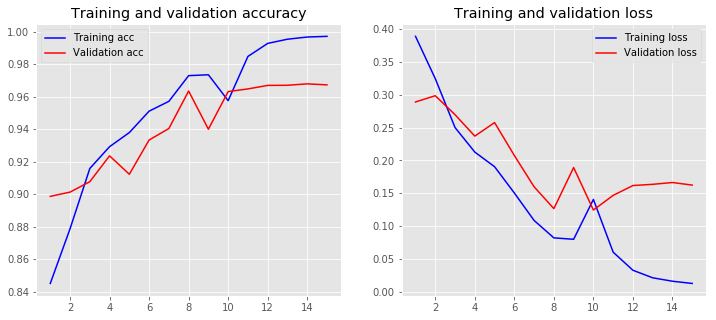

In [18]:
loss, accuracy = model2_large.evaluate(X_2_train_large, integer_encoded_train_large, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2_large.evaluate(X_2_test_large, integer_encoded_test_large, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_large)

33000/33000 [==============================] - ETA: 45 - ETA: 20 - ETA: 16 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

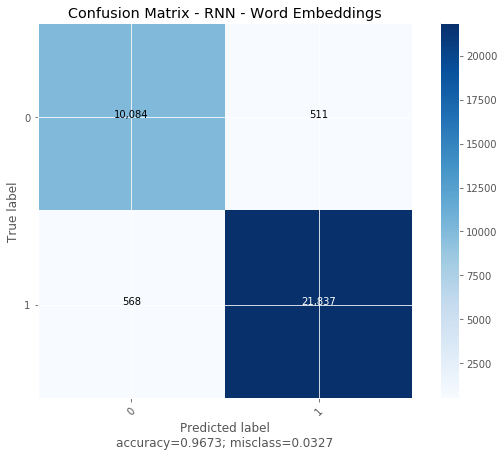

In [19]:
keras_pred2_large = model2_large.predict_classes(X_2_test_large, batch_size=50, verbose=1)
keras_cm2_large = metrics.confusion_matrix(integer_encoded_test_large, keras_pred2_large, labels=[0, 1])
plot_confusion_matrix(cm=keras_cm2_large, normalize=False, target_names=[0, 1],
                      title = 'Confusion Matrix - RNN - Word Embeddings')